# Final Results Analysis


## Load Data

In [1]:
import sys
from gepa_artifact import benchmarks
sys.modules['langProBe'] = benchmarks
sys.modules['benchmarks'] = benchmarks
sys.modules['benchmarks.langProBe.langProBe.langProBe'] = benchmarks

import pandas as pd
import json
import os

def read_data(expr_config_path, opt, bench):
    try:
        results_path = os.path.join(expr_config_path, "evaluation_results", "evaluation_result.txt")
        csv_f = pd.read_csv(results_path, index_col=1)
        score = csv_f.iloc[0]["score"]
        
        data_dict = {
            "score": score,
            **{"rescsv_" + k:v for k,v in csv_f.iloc[0].items() if k != "score"},
        }
    except Exception as e:
        print(e)
        data_dict = {
            "score": None
        }

    if "MIPRO" in opt:
        with open(os.path.join(expr_config_path, "run_log_stderr.txt"), "r") as f:
            log_data = f.readlines()
        
        valset_size = None
        for line in log_data:
            # "valset size: 300"
            line = line.strip()
            if "valset size: " in line:
                valset_size = int(line.split("valset size: ")[1].strip())
                break
        
        assert valset_size is not None, "Could not find valset size in log data."
        
        if os.path.exists(os.path.join(expr_config_path, "metric_logs", "test")):
            filename = os.listdir(os.path.join(expr_config_path, "metric_logs", "test"))[0]
            with open(os.path.join(expr_config_path, "metric_logs", "test", filename), "r") as f:
                metric_data = json.load(f)
        elif os.path.exists(os.path.join(expr_config_path, "metric_logs", "test.jsonl")):
            with open(os.path.join(expr_config_path, "metric_logs", "test.jsonl"), "r") as f:
                metric_data = json.loads(f.readline())
        else:
            raise FileNotFoundError("Could not find metric logs in the expected locations.")
        
        num_train_rollouts = metric_data["train_counter"]
        
        full_eval_scores_final = []
        full_eval_scores = None

        for line in log_data:
            line = line.strip()
            # Read the last such line:
            # mipro_optimizer_v2: Full eval scores so far: [33.33, 43.0, 41.33, 39.33, 36.33, 39.67, 39.67, 45.67, 40.67, 39.67, 33.33, 37.67, 38.33, 46.33, 45.0]
            if "Full eval scores so far:" in line:
                full_eval_scores = eval(line.split("Full eval scores so far: ")[1])
            
            if "Scores so far:" in line:
                full_eval_scores = eval(line.split("Scores so far: ")[1])
        
        full_eval_scores_read = []
        num_rollouts = [0]
        num_minibatches = 0
        for line in log_data:
            line = line.strip()
            if "Default program score:" in line:
                # Read the last such line:
                # Default program score: 45.0
                default_score = float(line.split("Default program score: ")[1])
                full_eval_scores_read.append(default_score)
            
            if "on minibatch of size " in line and "Score: " in line:
                assert "on minibatch of size 35" in line, "Unexpected minibatch size in log data."
                num_minibatches += 1
            
            if "Full eval scores so far:" in line:
                full_eval_scores_new = eval(line.split("Full eval scores so far: ")[1])
                assert len(full_eval_scores_new) - len(full_eval_scores_read) <= 1, "Mismatch in number of full eval scores read."
                if len(full_eval_scores_new) > len(full_eval_scores_read):
                    assert full_eval_scores_new[:-1] == full_eval_scores_read, "Mismatch in full eval scores read."
                    full_eval_scores_read.append(full_eval_scores_new[-1])
                    num_rollouts.append(num_train_rollouts + num_minibatches*35 + (len(full_eval_scores_read)-1)*valset_size)
            
            if "Scores so far:" in line:
                full_eval_scores_new = eval(line.split("Scores so far: ")[1])
                assert len(full_eval_scores_new) - len(full_eval_scores_read) <= 1, "Mismatch in number of full eval scores read."
                if len(full_eval_scores_new) > len(full_eval_scores_read):
                    assert full_eval_scores_new[:-1] == full_eval_scores_read, "Mismatch in full eval scores read."
                    full_eval_scores_read.append(full_eval_scores_new[-1])
                    num_rollouts.append(num_train_rollouts + num_minibatches*35 + (len(full_eval_scores_read)-1)*valset_size)
        
        assert full_eval_scores is not None, ("Full eval scores not found in log data.", expr_config_path)
        
        assert len(full_eval_scores_read) == len(num_rollouts), "Mismatch in number of full eval scores and num_rollouts."
        assert full_eval_scores_read == full_eval_scores, "Mismatch in full eval scores read from log data and computed full eval scores."
        assert len(full_eval_scores) > 0, "No full eval scores found in log data."
        unaccounted_valset_calls = 0
        if (num_minibatches * 35 + len(full_eval_scores_read) * valset_size) >= metric_data['val_counter']:
            pass
        else:
            unaccounted_valset_calls = metric_data['val_counter'] - (num_minibatches * 35 + len(full_eval_scores_read) * valset_size)
        
        for idx in range(1, len(num_rollouts)):
            num_rollouts[idx] += unaccounted_valset_calls

        data_dict["full_eval_scores"] = full_eval_scores
        data_dict["num_rollouts"] = num_rollouts
        data_dict['bootstrap_metric_calls'] = metric_data['train_counter'] + unaccounted_valset_calls
        data_dict['search_calls'] = num_minibatches * 35 + len(full_eval_scores_read) * valset_size
        data_dict['total_rollouts'] = data_dict['bootstrap_metric_calls'] + data_dict['search_calls']
        data_dict['experiment_config'] = expr_config_path

        progs = [None]
        
        for prog_name in os.listdir(os.path.join(expr_config_path, "optimizer_logs", "evaluated_programs")):
            prog_path = os.path.join(expr_config_path, "optimizer_logs", "evaluated_programs", prog_name)
            if prog_name == "program_-1":
                import dspy
                progs[0] = (0, dspy.load(prog_path))
            elif "full_eval" in prog_name:
                # program_{idx}_full_eval
                idx = int(prog_name.split("_")[1])
                import dspy
                progs.append((idx, dspy.load(prog_path)))
        
        assert len(progs) > 0, "No programs found in optimizer logs."
        assert progs[0] is not None, "First program should not be None."
        assert len(progs) == len(data_dict["full_eval_scores"]), "Mismatch in number of programs and full eval scores."
        # Sort programs by index
        progs = sorted(progs, key=lambda x: x[0])
        progs = [prog for idx, prog in progs if prog is not None]
        data_dict['programs'] = progs
    if "GEPA" in opt or opt == 'Abl-SelectBestCandidate':
        from gepa_artifact.gepa.gepa_utils import GEPAState
        gepa_state = GEPAState.load(expr_config_path)
        data_dict["num_rollouts"], data_dict["full_eval_scores"] = gepa_state.num_metric_calls_by_discovery, gepa_state.program_full_scores_val_set
        data_dict['parent_program_for_candidate'] = gepa_state.parent_program_for_candidate
        data_dict['pareto_front_programs'] = gepa_state.program_at_pareto_front_valset
        data_dict['gepa_state'] = gepa_state
        data_dict['programs'] = gepa_state.program_candidates

    if "GRPO" in opt:
        # Open run_log_stderr.txt
        # Student program validation set score before training loop: 66.01
        # Student program validation set score after training step 60/500: 72.17
        with open(os.path.join(expr_config_path, "run_log_stderr.txt"), "r") as f:
            log_data = f.readlines()

        num_rollouts = [0]
        full_eval_scores = []
        
        for line in log_data:
            if "Student program validation set score before training loop:" in line:
                full_eval_scores.append(eval(line.split("Student program validation set score before training loop: ")[1]))
            if "Student program validation set score after training step" in line:
                assert len(line.split("/500: ")) == 2, line
                full_eval_scores.append(eval(line.split("/500: ")[1]))
                num_rollouts.append(48*20*len(num_rollouts))

        assert abs(len(num_rollouts) - len(full_eval_scores)) <= 1
        max_len = min(len(num_rollouts), len(full_eval_scores))
        data_dict["num_rollouts"], data_dict["full_eval_scores"] = num_rollouts[:max_len], full_eval_scores[:max_len]
    
    return data_dict

data = []
for base_dir_paths in ["experiment_runs_data/experiment_runs"]:
    for seed_name in os.listdir(base_dir_paths):
        seed_path = os.path.join(base_dir_paths, seed_name)
        for expr_config in os.listdir(seed_path):
            expr_config_path = os.path.join(seed_path, expr_config)
            if "HotpotQABench_GeneratorCriticRanker" in expr_config:
                continue
            if "evaluation_results" in os.listdir(expr_config_path):
                assert "_backup_" not in expr_config, "Backup files should not be processed."
                bench, prog, opt, model = expr_config.split("_")
                if bench in ["SWEUnderspecified", "NPUEvalBench"]:
                    continue
                if "GRPO" in opt:
                    continue
                data.append({
                    "bench": bench,
                    "prog": prog,
                    "opt": opt,
                    "model": model,
                    "seed_name": seed_name,
                    **read_data(expr_config_path, opt, bench)
                })

longest_grpo_runs = {(d['bench'], d['prog'], d['opt'], d['model'], d['seed_name']):d for d in data if "GRPO" in d['opt']}
for base_dir_paths in ["experiment_runs_data/experiment_runs"]:
    for seed_name in os.listdir(base_dir_paths):
        seed_path = os.path.join(base_dir_paths, seed_name)
        for expr_config in os.listdir(seed_path):
            expr_config_path = os.path.join(seed_path, expr_config)
            if "_backup_" in expr_config:
                bench, prog, opt, model = expr_config.split("_backup_")[0].split("_")
            else:
                bench, prog, opt, model = expr_config.split("_")
            if "GRPO" in opt:
                run_d = {
                    "bench": bench,
                    "prog": prog,
                    "opt": opt,
                    "model": model,
                    "seed_name": seed_name,
                    **read_data(expr_config_path, opt, bench)
                }
                if (bench, prog, opt, model, seed_name) not in longest_grpo_runs or len(longest_grpo_runs[(bench, prog, opt, model, seed_name)]['num_rollouts']) < len(run_d['num_rollouts']):
                    longest_grpo_runs[(bench, prog, opt, model, seed_name)] = run_d

data.extend(longest_grpo_runs.values())

df = pd.DataFrame(data)

/data/lakshyaaagrawal/GEPA_Code_Release/GEPA_artifact/.venv/lib/python3.12/site-packages/syllapy/data_loader.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 11.6 MB/s  0:00:01a 0:00:01m eta 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [2]:
df['opt'] = df['opt'].replace('Abl-SelectBestCandidate', 'GEPA-Abl-SBC')

df['num_rollouts'] = df['num_rollouts'].apply(lambda x: eval(x) if isinstance(x, str) else x)
df['full_eval_scores'] = df['full_eval_scores'].apply(lambda x: eval(x) if isinstance(x, str) else x)
df['best_validation_score'] = df['full_eval_scores'].apply(lambda x: max(x) if isinstance(x, list) else x)
df['generalization_gap'] = df['best_validation_score'] - df['score']

df['opt'] = df['opt'].str.replace('8-Heavy', '')
df['opt'] = df['opt'].str.replace('-Heavy', '')

import numpy as np
df['best_program_idx'] = df['full_eval_scores'].apply(lambda x: np.argmax(x) if isinstance(x, list) else None).astype(pd.Int64Dtype())
df['num_rollouts_for_best_program'] = df.apply(lambda row: row['num_rollouts'][row['best_program_idx']] if isinstance(row['num_rollouts'], list) and row['best_program_idx'] is not None else None, axis=1)
df['base_val_score'] = df['full_eval_scores'].apply(lambda x: x[0] if isinstance(x, list) else x)

def f(x):
    bench, model, prog = x['bench'], x['model'], x['prog']
    miprov2_row = df.loc[df['bench'] == bench].loc[df['model'] == model].loc[df['prog'] == prog].loc[df['opt'] == 'MIPROv2']
    assert miprov2_row.shape[0] == 1, f"Expected exactly one MIPROv2 row for {bench}, {model}, {prog}, found {miprov2_row.shape[0]}"
    miprov2_row = miprov2_row.iloc[0]
    valset_score = miprov2_row['full_eval_scores'][0]
    return valset_score

df.loc[df['opt'] == 'Baseline', 'best_validation_score'] = df.loc[df['opt'] == 'Baseline'].apply(f, axis=1)
df['last_rollout_for_prog_discovered'] = df['num_rollouts'].apply(lambda x: x[-1] if isinstance(x, list) else x)
df['is_prompt_opt'] = (df['opt'].str.contains('GEPA') | df['opt'].str.contains('MIPRO'))
df['best_program'] = df.apply(lambda x: x['programs'][x['best_program_idx']] if isinstance(x['programs'], list) else None, axis=1)

def f(x):
    if not isinstance(x, list):
        return x

    base_score = x[0]
    # return [score / base_score for score in x]
    return x

df['full_eval_scores_normalized'] = df['full_eval_scores'].apply(f)

# budget_normalizer = df.groupby(['bench', 'prog', 'model']).apply(lambda x: x.loc[x['opt'] == 'MIPROv2'].iloc[0]['num_rollouts'][-1]).to_dict()
# budget_normalizer = df.groupby(['bench', 'prog', 'model']).apply(lambda x: x.loc[x['opt'] == 'MIPROv2'].iloc[0]['total_rollouts']).to_dict()
budget_normalizer = df.groupby(['bench', 'prog', 'model']).apply(lambda x: 24000).to_dict()
df['num_rollouts_normalized'] = df.apply(lambda row: [r / budget_normalizer[(row['bench'], row['prog'], row['model'])] for r in row['num_rollouts']] if isinstance(row['num_rollouts'], list) else row['num_rollouts'], axis=1)

def f(x):
    return pd.Series(x).cummax().to_list() if isinstance(x, list) else x

df['full_eval_scores_normalized'] = df['full_eval_scores_normalized'].apply(f)

num_benchmarks = len(['hoverBench', 'IFBench', 'HotpotQABench', 'Papillon']) # 'FacilitySupportAnalyzerBench', 
num_models = len(['qwen3-8b', 'gpt-41-mini'])
num_optimizers = len(['GEPA-MERGEWLinear8-Heavy', 'GEPA8-Heavy', 'MIPROv2-Heavy',
       'Baseline', 'GEPA-Abl-SBC8-Heavy', 'GEPA-MERGE8-Heavy', 'GRPO'])

assert not df.loc[df['opt'] != 'Baseline']['num_rollouts'].isna().any()
assert not df.loc[df['opt'] != 'Baseline']['full_eval_scores'].isna().any()
assert not df['score'].isna().any()

/tmp/ipykernel_1719417/3420068549.py:41: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  budget_normalizer = df.groupby(['bench', 'prog', 'model']).apply(lambda x: 24000).to_dict()


## Main Results Table

In [3]:
import numpy as np
import pandas as pd
from IPython.display import display, Markdown

def format_improvement(x):
    if pd.isna(x): return ''
    return f'{x:+.2f}'

def format_value(x):
    if pd.isna(x): return '-'
    return f'{x:.2f}'

for model_name in df['model'].unique():
    display(Markdown(f"### Model: **{model_name}**"))
    xdf = df.loc[df['model'] == model_name].pivot(
        index=['opt'],
        columns=['bench', 'prog'],
        values='score'
    )

    opts_order = ['Baseline', 'MIPROv2', 'GRPO', 'GEPA', 'GEPA-MERGE'] # 'GEPA-Abl-SBC', 
    xdf = xdf.reindex(opts_order)
    xdf = xdf.loc[xdf.index[~xdf.isna().all(axis=1)]]
    xdf = xdf.sort_index(axis=1)
    xdf['aggregate'] = xdf[xdf.columns[~xdf.isna().any()]].mean(axis=1) # xdf.mean(axis=1)
    xdf['improvement'] = (xdf[xdf.columns[~xdf.isna().any()]].drop(columns=['aggregate']) - xdf[xdf.columns[~xdf.isna().any()]].loc[xdf.index.str.contains('Baseline')].iloc[0]).mean(axis=1)

    def custom_highlight_max(s):
        is_max = s == s.max(skipna=True)
        return ['font-weight: bold; background-color: #e8f7e4' if v else '' for v in is_max]

    # Build columns for formatting
    main_cols = [col for col in xdf.columns if col not in ['aggregate', 'improvement']]
    formatters = {col: format_value for col in main_cols}
    formatters.update({'aggregate': format_value, 'improvement': format_improvement})

    styled = (xdf
        .style
        .apply(custom_highlight_max, axis=0)
        .format(formatters, na_rep='-')
        .background_gradient(subset=['aggregate', 'improvement'], cmap='YlGn', axis=0)
        .set_table_styles([
            {'selector': 'th', 'props': [('font-size', '110%'), ('background', '#f3f3f3')]},
            {'selector': 'thead tr:nth-child(2) th', 'props': [('font-size', '100%'), ('font-style', 'italic')]},
            {'selector': 'tr:nth-child(even)', 'props': [('background-color', '#f9f9f9')]},
            {'selector': 'tr:nth-child(odd)', 'props': [('background-color', '#ffffff')]}
        ])
        .set_properties(**{
            'border': '1px solid #ccc',
            'padding': '6px 12px'
        })
    )
    display(styled)

### Model: **gpt-41-mini**

bench,AIMEBench,HotpotQABench,IFBench,LiveBenchMathBench,Papillon,hoverBench,aggregate,improvement
prog,CoT,HotpotMultiHop,IFBenchCoT2StageProgram,CoT,PAPILLON,HoverMultiHop,,
opt,,,,,,,,
Baseline,49.33,38.00,47.79,58.20,78.57,46.33,53.78,0.00
MIPROv2,51.33,58.00,49.15,61.84,83.37,48.33,60.14,6.36
GEPA,59.33,69.00,52.72,59.43,94.47,51.67,65.46,11.68
GEPA-MERGE,-,65.67,55.95,64.13,96.46,56.67,67.78,14.00


### Model: **qwen3-8b**

bench,HotpotQABench,IFBench,Papillon,hoverBench,aggregate,improvement
prog,HotpotMultiHop,IFBenchCoT2StageProgram,PAPILLON,HoverMultiHop,,
opt,,,,,,
Baseline,42.33,36.90,80.82,35.33,48.84,0.00
MIPROv2,55.33,36.22,81.55,47.33,55.11,6.26
GRPO,43.33,35.88,86.66,38.67,51.14,2.29
GEPA,62.33,38.61,91.85,52.33,61.28,12.44
GEPA-MERGE,64.33,28.23,86.26,51.67,57.62,8.78


In [4]:
color_map = {
    'Baseline': '#888888',        # grey
    'MIPROv2': '#44b36d',         # green
    'GRPO': '#f5a142',            # orange
    'GEPA-Abl-SBC': '#bbdefb',     # light blue
    # 'GEPA-MERGEWLinear': '#64b5f6', # medium blue
    'GEPA': '#1976d2',            # deep blue
    'GEPA-MERGE': '#0d47a1',      # darkest blue
}

# =================== Font and Style Configurations ===================

from matplotlib.font_manager import FontProperties
XTICK_FONT = {'fontsize': 18, 'fontweight': 'bold'}
YTICK_FONT = {'fontsize': 18, 'fontweight': 'bold'}
TITLE_FONT = {'fontsize': 22, 'fontweight': 'bold'}
YLABEL_FONT = {'fontsize': 20, 'fontweight': 'bold'}
ANNOT_FONT = {'fontsize': 13.5, 'fontweight': 'bold'}  # For ax.text
LEGEND_FONT = FontProperties(family='sans-serif', size=15, weight='bold')
# =====================================================================

model_nickname = {
    'qwen3-8b': 'Qwen3 8B',
    'gpt-41-mini': 'GPT-4.1 Mini',
}

benchmark_nicknames = {
    'hoverBench': 'HoVer',
    'IFBench': 'IFBench',
    'HotpotQABench': 'HotpotQA',
    'Papillon': 'PUPA',
    'AIMEBench': 'AIME2025',
    'LiveBenchMathBench': 'LiveBench Math',
    'aggregate': 'Aggregate',
}

opt_nicknames = {
    'Baseline': 'Baseline',        # grey
    'MIPROv2': 'MIPROv2',         # green
    'GRPO': 'GRPO (24000 rollouts)', # orange
    'GEPA-Abl-SBC': 'GEPA-Abl-SBC',     # light blue
    # 'GEPA-MERGEWLinear': 'GEPA-BaselineLM', # medium blue
    'GEPA': 'GEPA',            # deep blue
    'GEPA-MERGE': 'GEPA+Merge',      # darkest blue
}

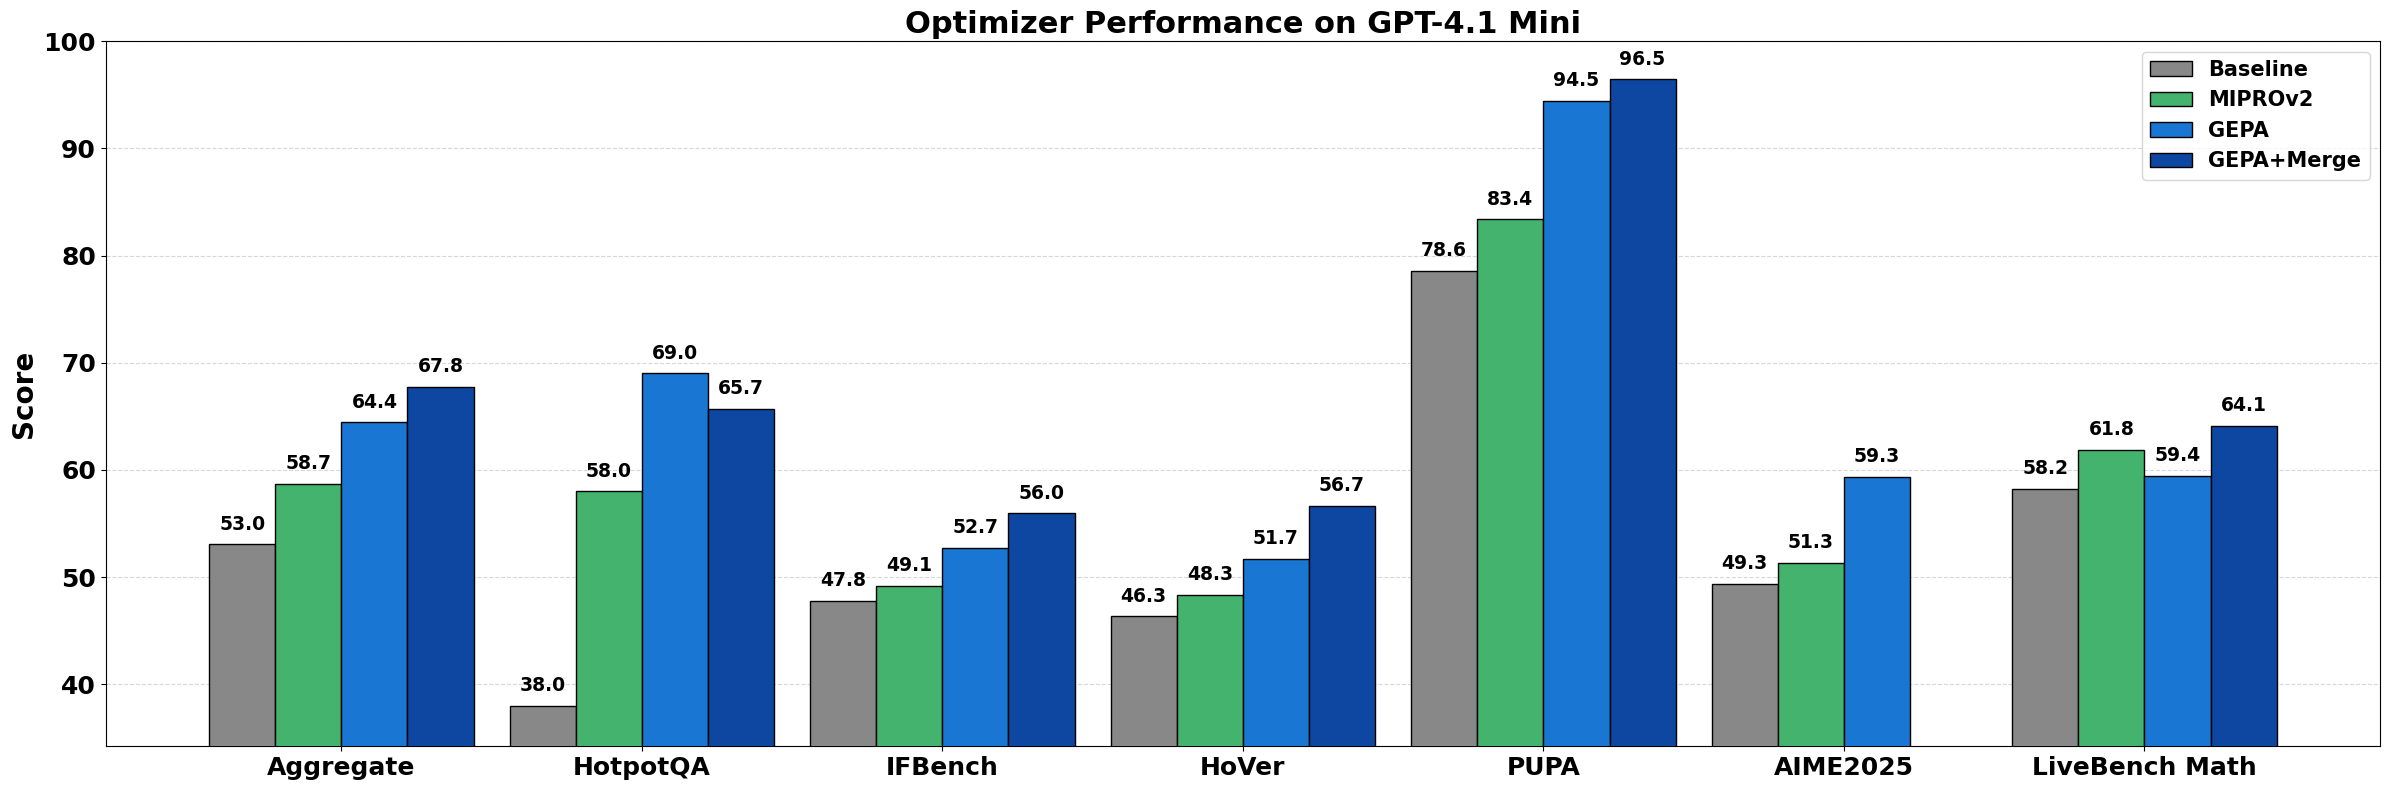

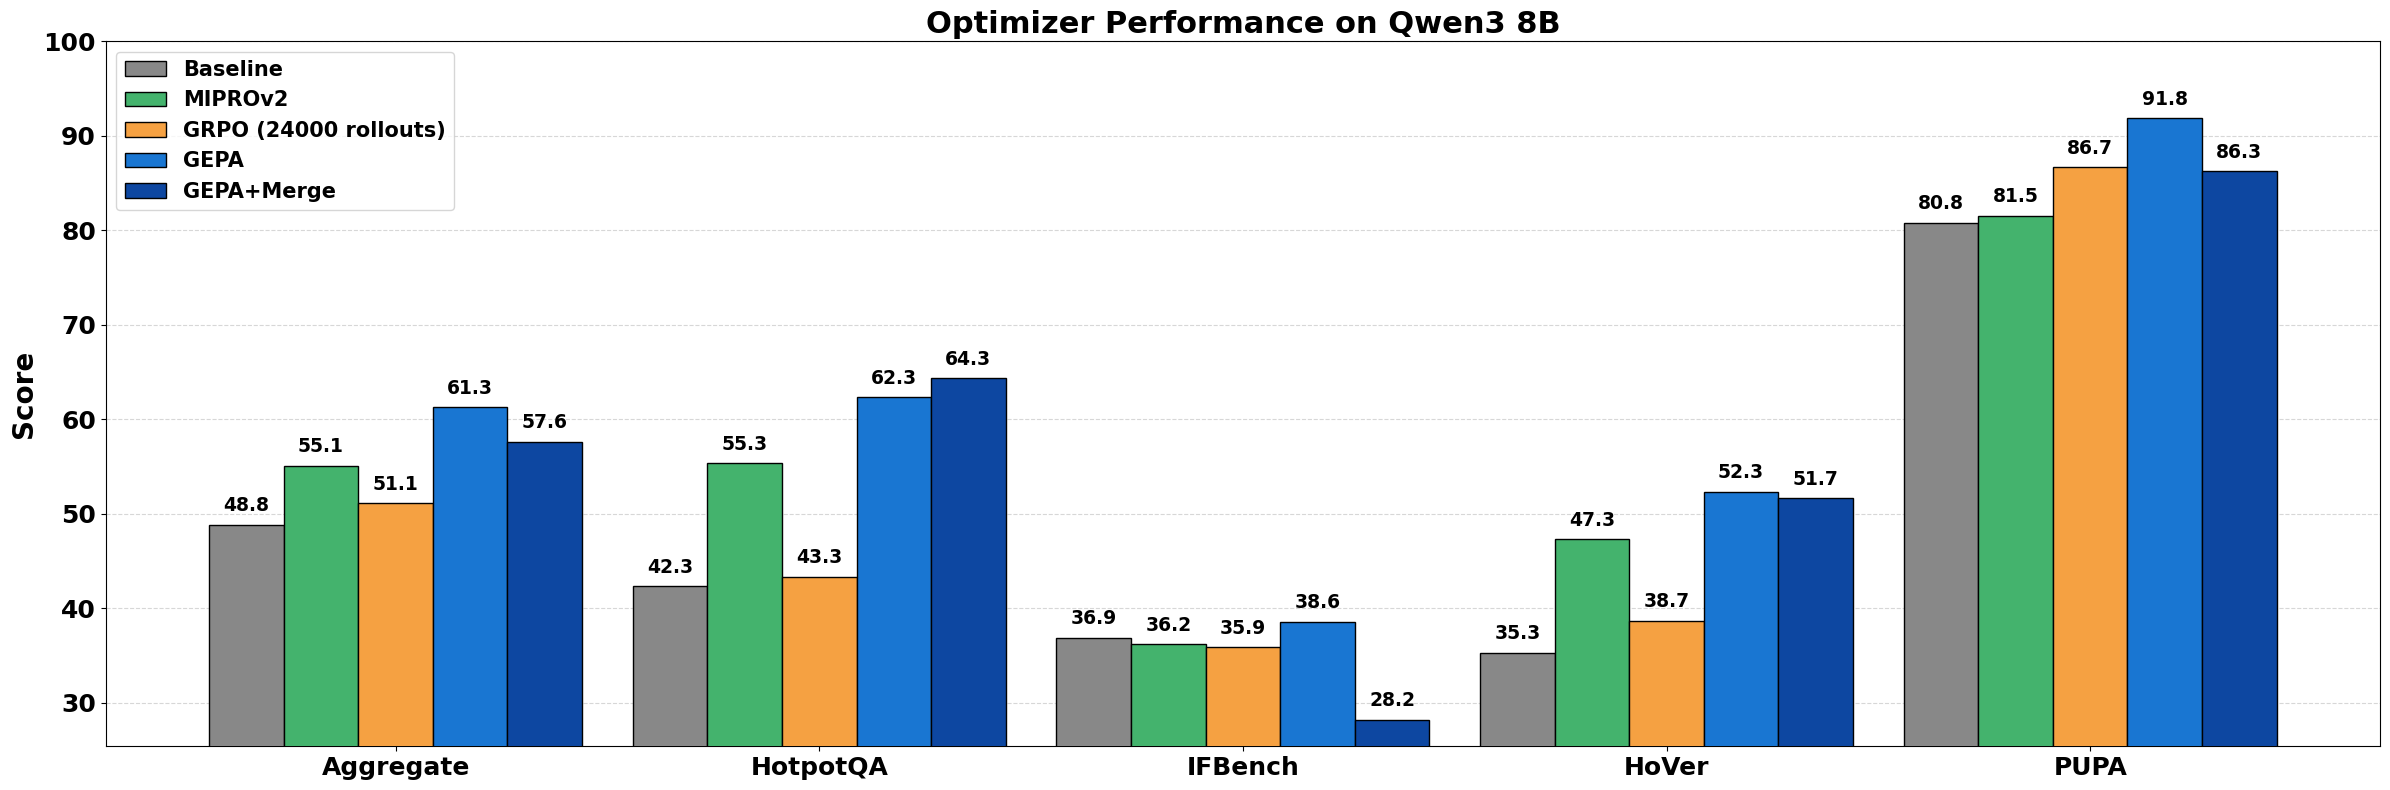

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Optimizers, in desired order
opts_order = ['Baseline', 'MIPROv2', 'GRPO', 'GEPA', 'GEPA-MERGE'] # 'GEPA-Abl-SBC', 'GEPA-MERGEWLinear', 

# Benchmarks, as tuples in multiindex
bench_prog_columns = [
    ('HotpotQABench','HotpotMultiHop'),
    ('IFBench','IFBenchCoT2StageProgram'),
    ('hoverBench','HoverMultiHop'),
    ('Papillon','PAPILLON'),
    ('AIMEBench','CoT'),
    ('LiveBenchMathBench','CoT'),
]

# Labels for x-axis (must match order above, with "Aggregate" first)
column_labels = [
    'Aggregate',
    'HotpotQA',
    'IFBench',
    'HoverBench',
    'Papillon',
    'AIME2025',
    'LiveBench-Math',
]

column_labels = [benchmark_nicknames.get(col, col) for col in column_labels]

for model_name in df['model'].unique():
    # Pivot as in your code
    xdf = df.loc[df['model'] == model_name].pivot(
        index=['opt'],
        columns=['bench', 'prog'],
        values='score'
    )
    # Reindex opts, keep only those present
    xdf = xdf.reindex(opts_order)
    xdf = xdf.loc[xdf.index[~xdf.isna().all(axis=1)]]

    # Compute 'aggregate' column (mean over benchmarks)
    xdf['aggregate'] = xdf.mean(axis=1)

    # # Ensure all benches present (add empty columns if missing)
    # for col in bench_prog_columns:
    #     if col not in xdf.columns:
    #         xdf[col] = np.nan

    # Order columns for plotting: aggregate, then each benchmark
    # As MultiIndex: [(aggregate, ''), ...], rest as in bench_prog_columns
    new_bench_prog_columns = [col for col in bench_prog_columns if col in xdf.columns]
    multi_cols = [('aggregate', '')] + new_bench_prog_columns
    plot_df = xdf[multi_cols]
    
    # --- FIXED: Check membership before accessing .loc[opt]
    present_opts = [opt for opt in opts_order if opt in plot_df.index and not plot_df.loc[opt].isna().all()]

    # Only use rows for present_opts
    plot_df = plot_df.loc[present_opts]

    n_opts = len(present_opts)
    n_benches = plot_df.shape[1]
    x = np.arange(n_benches)

    group_width = 0.88  # Bars will fill 80% of the group
    bar_width = group_width / n_opts  # Each bar gets equal width in the group

    fig, ax = plt.subplots(figsize=(24,8))

    for i, opt in enumerate(present_opts):
        opt_color = color_map.get(opt, '#bbbbbb')
        y = plot_df.loc[opt].values
        # Bar positions, centered
        bar_pos = x - group_width/2 + i*bar_width + bar_width/2
        bars = ax.bar(
            bar_pos,
            y,
            width=bar_width,
            label=opt_nicknames.get(opt, opt),
            color=opt_color,
            edgecolor='k',
            zorder=3
        )
        for xi, val in zip(bar_pos, y):
            if not np.isnan(val):
                ax.text(xi, val + 1, f"{val:.1f}", ha='center', va='bottom', **ANNOT_FONT)

    # Set y-lims:
    y_min = max(0, 0.9*plot_df.min().min())
    y_max = min(100, plot_df.max().max() * 1.1)
    ax.set_ylim(y_min, y_max)
    
    ax.set_xticks(x)
    column_labels_new = [benchmark_nicknames.get(col[0], col[0]) if isinstance(col, tuple) else col for col in plot_df.columns]
    ax.set_xticklabels(column_labels_new, **XTICK_FONT)
    ax.set_ylabel('Score', **YLABEL_FONT)
    ax.set_title(f'Optimizer Performance on {model_nickname.get(model_name, model_name)}', **TITLE_FONT)
    # Y ticks font:
    for label in ax.get_yticklabels():
        label.set_fontsize(YTICK_FONT['fontsize'])
        label.set_fontweight(YTICK_FONT['fontweight'])
    ax.legend(prop=LEGEND_FONT) # loc='upper left', bbox_to_anchor=(1,1), 
    ax.grid(True, axis='y', linestyle='--', alpha=0.5, zorder=0)
    plt.tight_layout()

    plt.savefig(f"figures/optimizer_performance_{model_name}.pdf", dpi=300)

    plt.show()

## Generalization Gap Plots

/tmp/ipykernel_1719417/1996162.py:5: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  xxdf = df.loc[~df['opt'].isin(['GRPO', 'GEPA-Abl-SBC', 'GEPA-MERGEWLinear'])].loc[df['bench'] != 'IFBench'].groupby(['model', 'bench', 'opt']).apply(f)


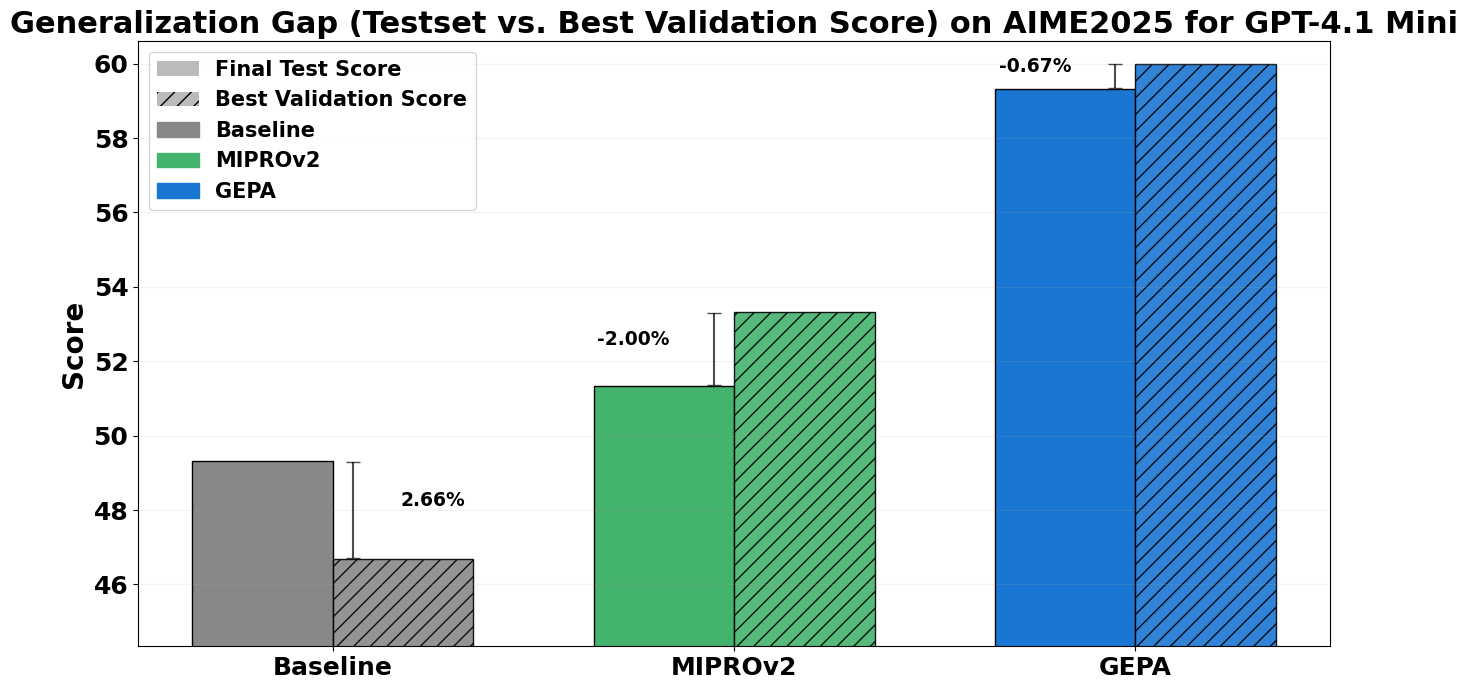

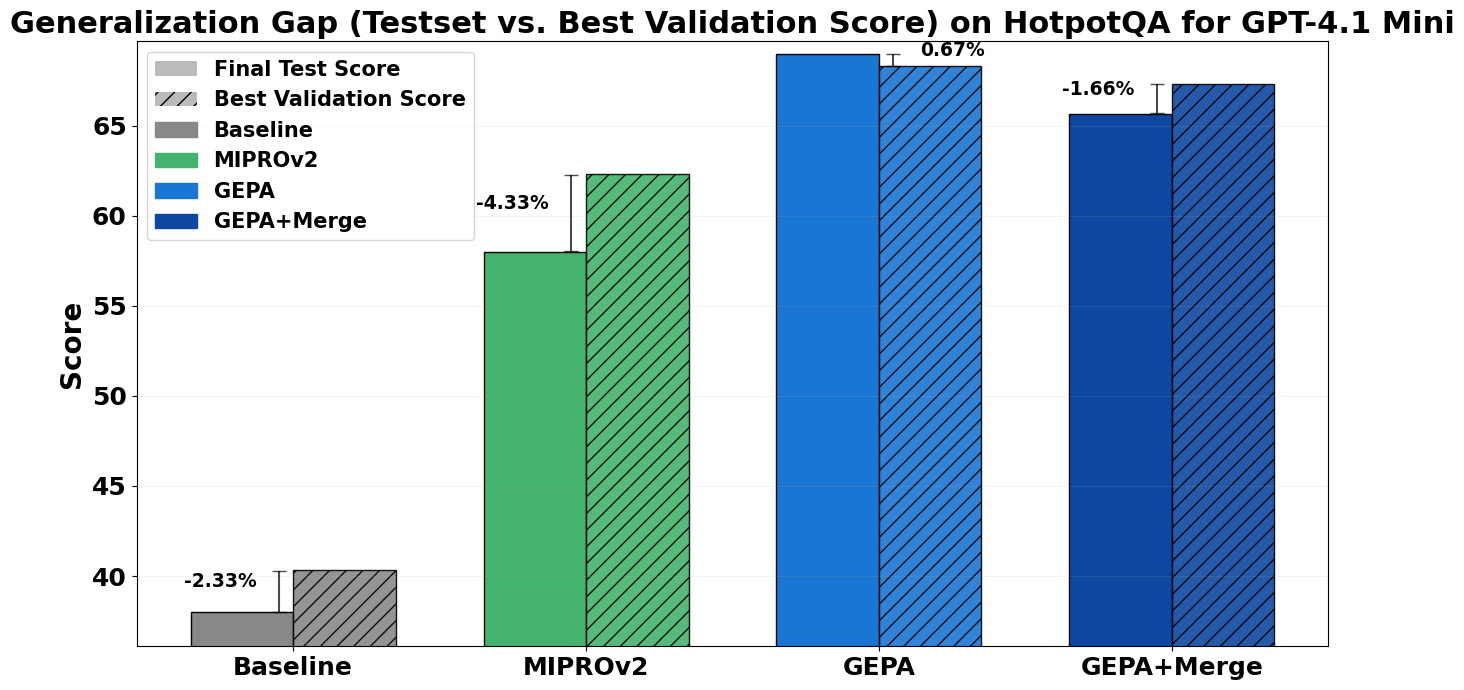

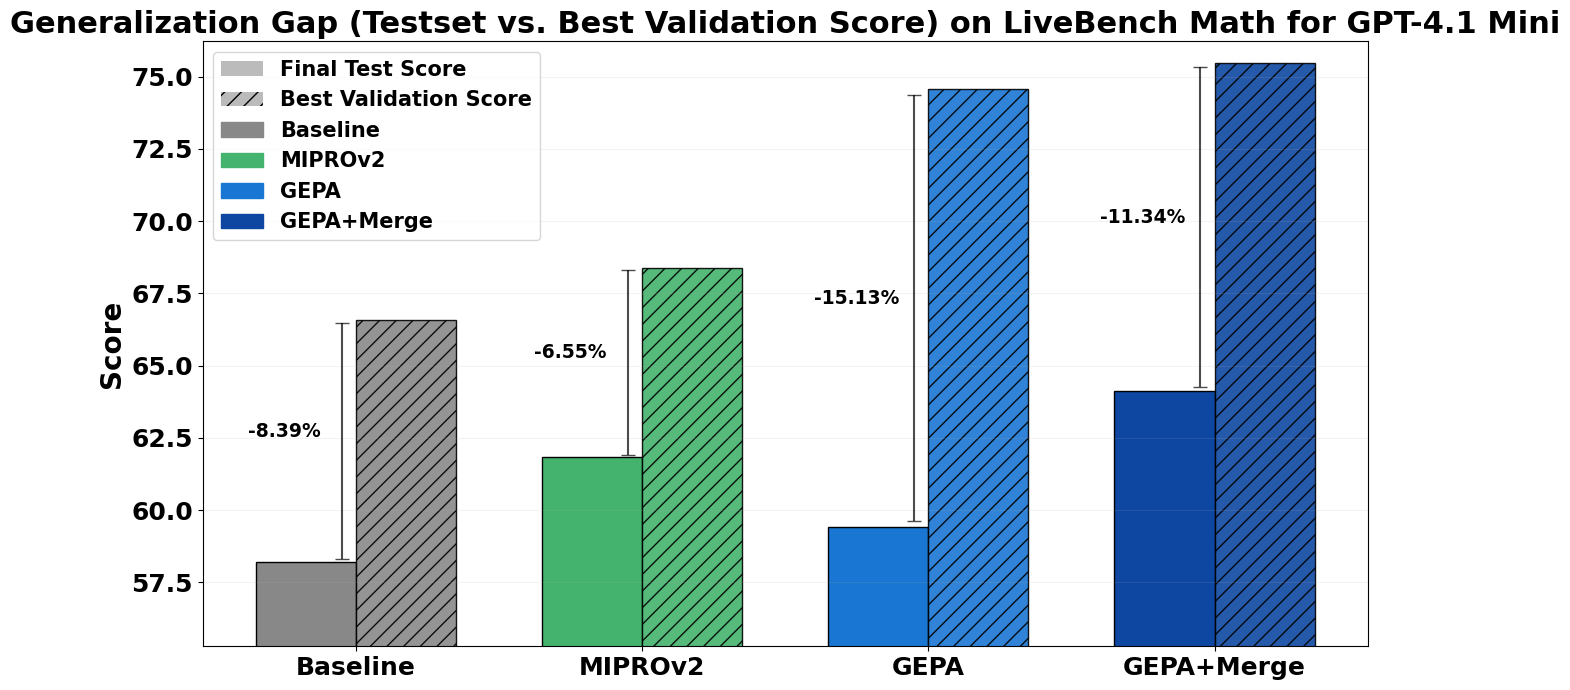

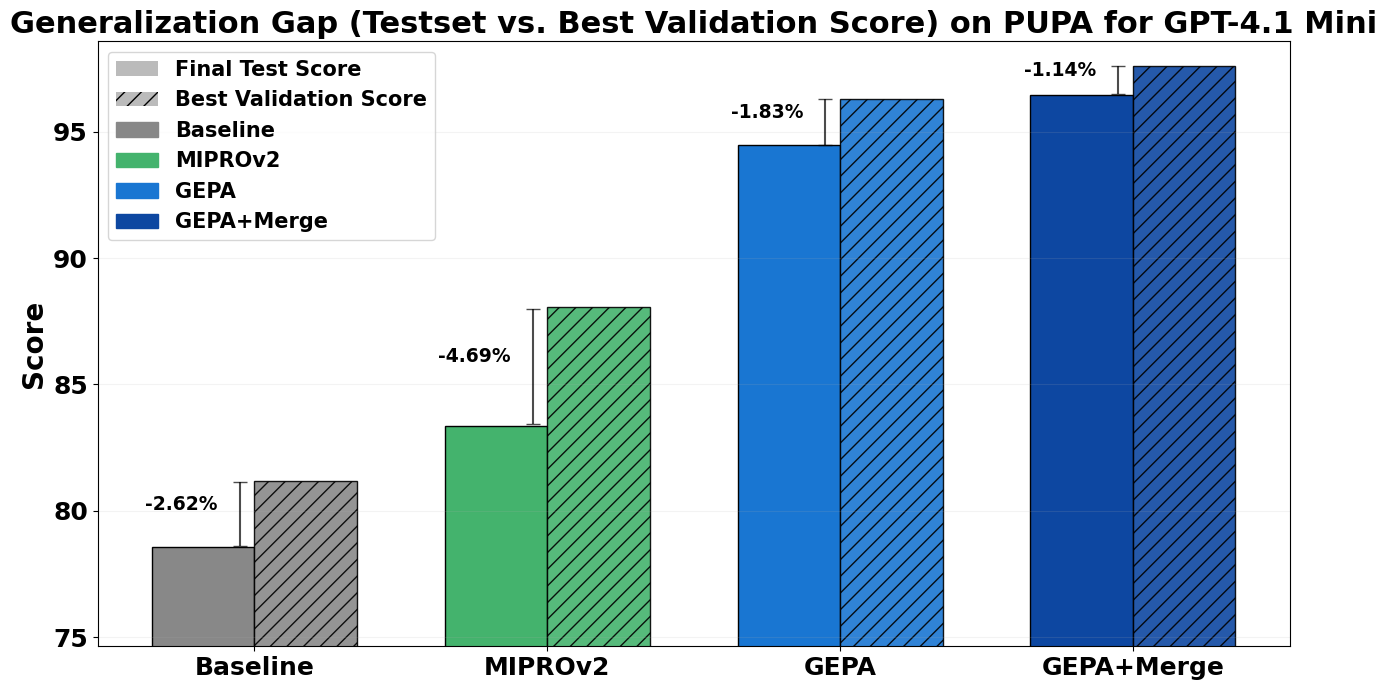

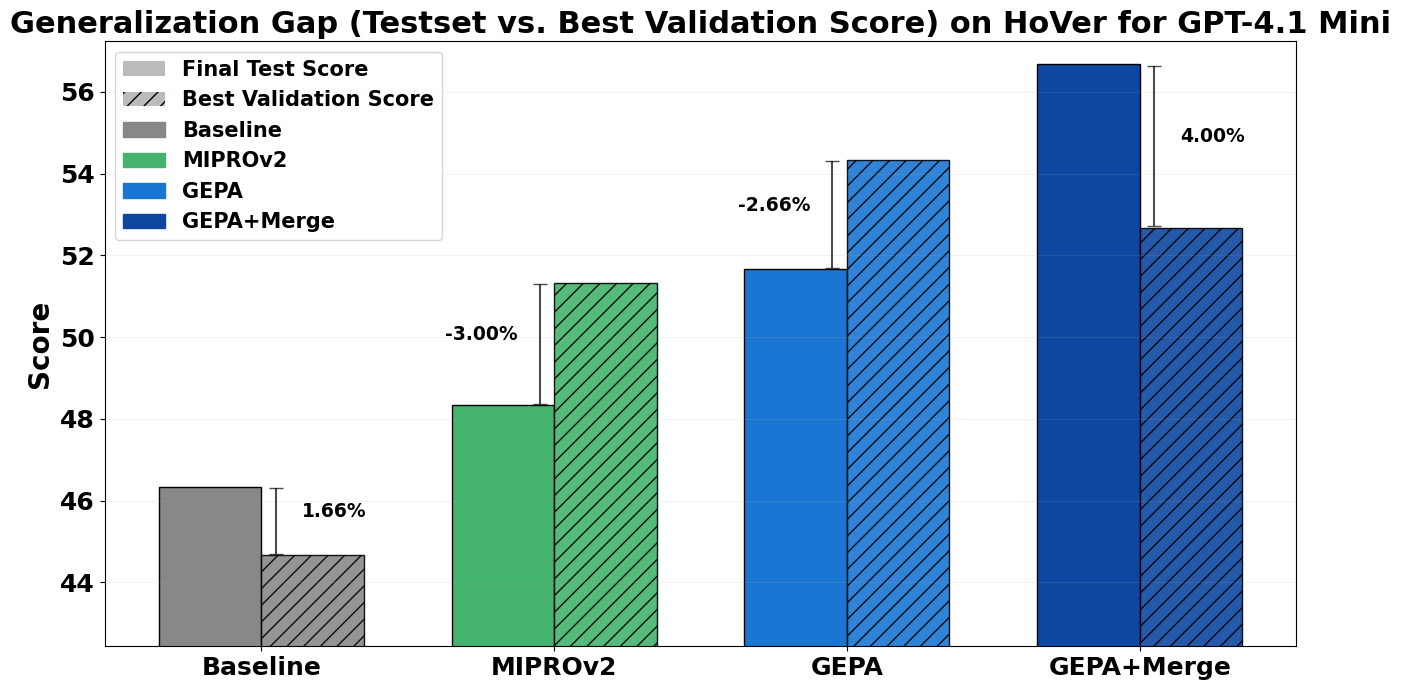

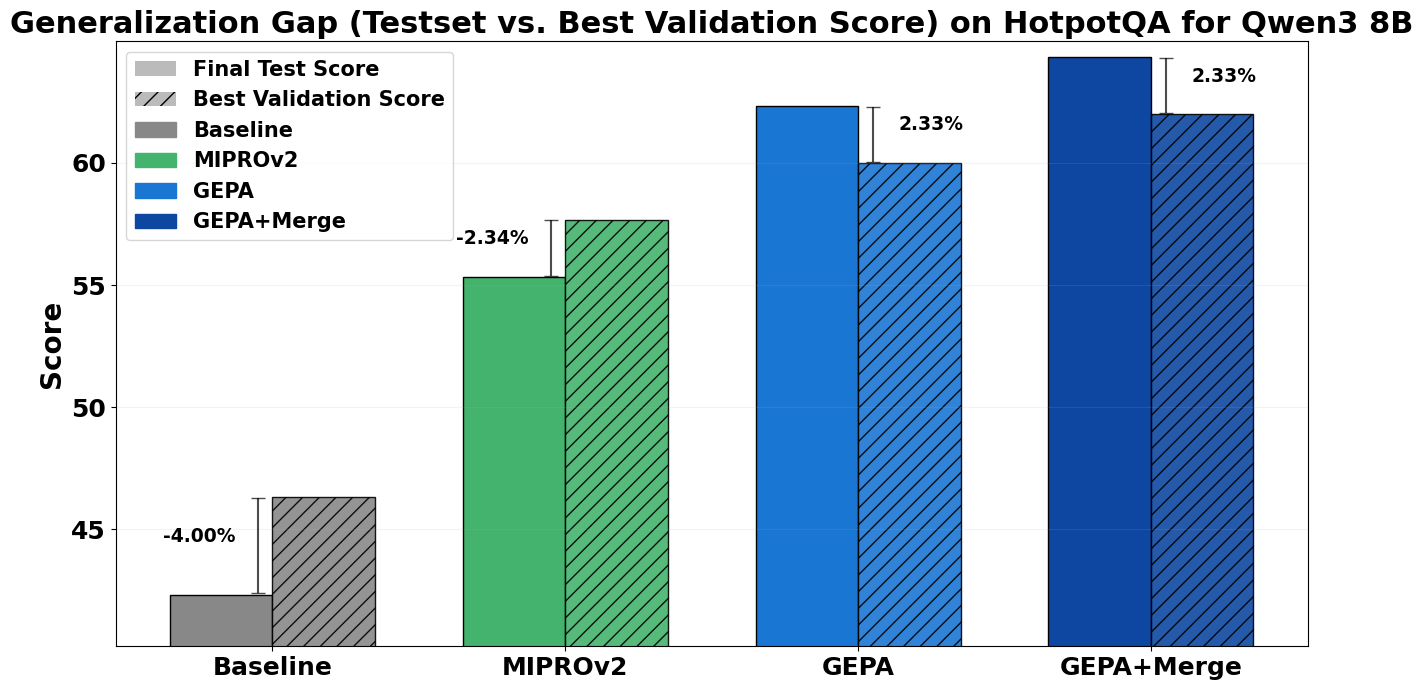

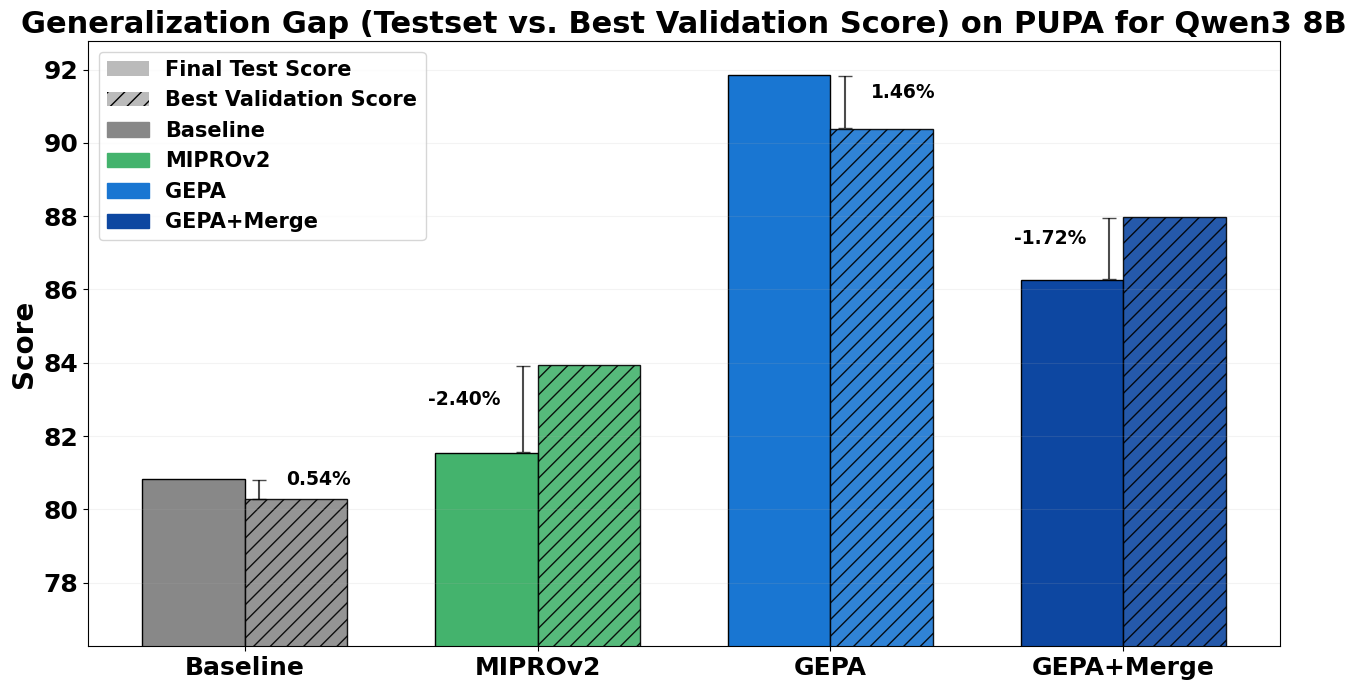

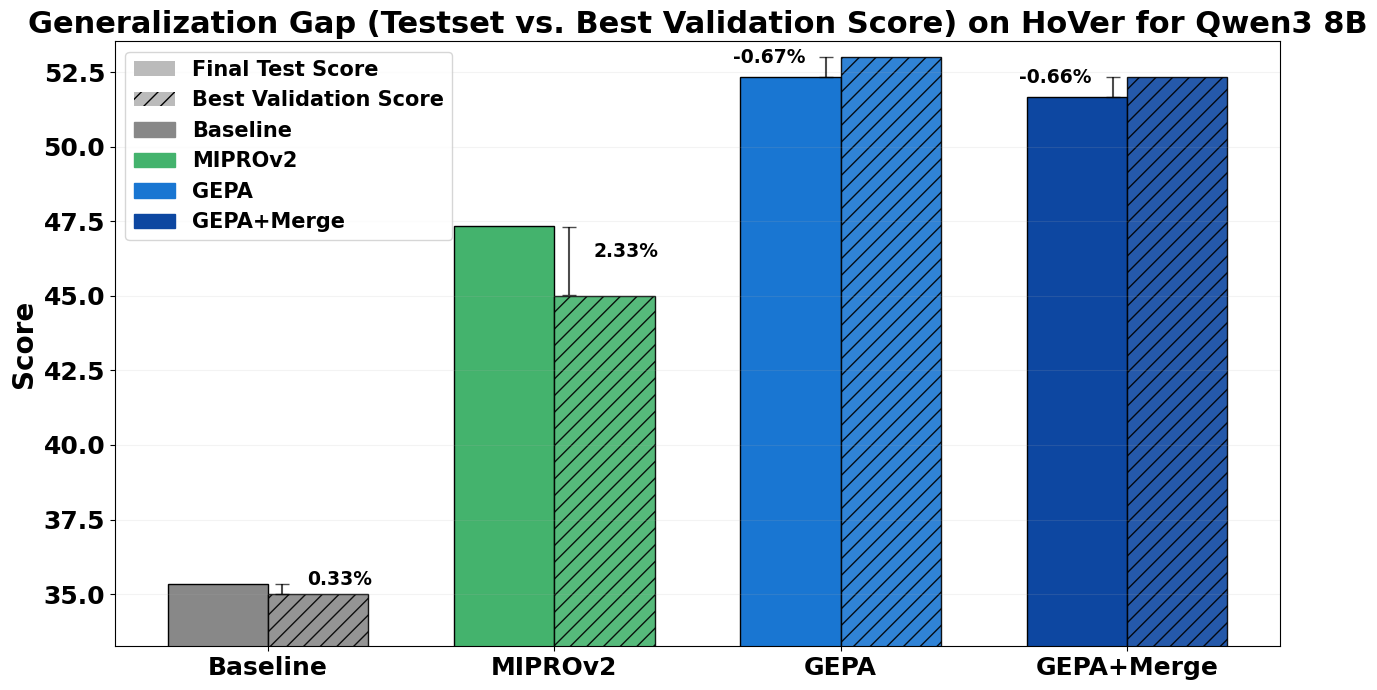

In [6]:
def f(x):
    assert x.shape[0] == 1, f"Expected exactly one row for {x['bench']}, {x['model']}, {x['prog']}, found {x.shape[0]}"
    return pd.Series({'score': x['score'].iloc[0], 'best_validation_score': x['best_validation_score'].iloc[0]})

xxdf = df.loc[~df['opt'].isin(['GRPO', 'GEPA-Abl-SBC', 'GEPA-MERGEWLinear'])].loc[df['bench'] != 'IFBench'].groupby(['model', 'bench', 'opt']).apply(f)

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

opt_order_1 = ['Baseline', 'MIPROv2', 'GEPA', 'GEPA-MERGE']
opt_order_2 = ['Baseline', 'MIPROv2', 'GRPO', 'GEPA', 'GEPA-MERGE']

for model in xxdf.index.get_level_values('model').unique():
    for bench in xxdf.index.get_level_values('bench').unique():
        try:
            plotdf = xxdf.loc[(model, bench)].reset_index()
        except:
            continue
        if 'GRPO' in plotdf['opt'].values:
            opt_order = opt_order_2
        else:
            opt_order = opt_order_1
        plotdf = plotdf.set_index('opt').reindex(opt_order).reset_index()
        plotdf = plotdf.loc[~plotdf['score'].isna()]
        
        x = np.arange(len(plotdf['opt']))
        width = 0.35

        fig, ax = plt.subplots(figsize=(13, 7))
        ax.grid(alpha=0.15, axis='y')
        final_colors = [color_map.get(o, '#cccccc') for o in plotdf['opt']]

        rects1 = ax.bar(x - width/2, plotdf['score'], width,
                        label='Final Test Score', color=final_colors, edgecolor='k')
        rects2 = ax.bar(x + width/2, plotdf['best_validation_score'], width,
                        label='Best Validation Score', color=final_colors, edgecolor='k', hatch='//', alpha=0.9)

        # === FIXED ANNOTATION LOOP ===
        for i, row in plotdf.iterrows():
            xi = x[i]
            score = row['score']
            val_score = row['best_validation_score']
            diff = score - val_score
            bar_bottom = min(score, val_score)
            bar_top = max(score, val_score)
            pos = xi - 0.05 if score < val_score else xi + 0.05
            ax.errorbar(pos, (bar_bottom+bar_top)/2, yerr=abs(diff/2.05),
                        color='k', alpha=0.7, capsize=5, elinewidth=1.5)
            text_pos = xi - 0.25 if score < val_score else xi + 0.25
            ax.text(
                text_pos, (bar_top+bar_bottom)/2, f"{diff:.2f}%",
                ha='center', va='bottom', color='k', **ANNOT_FONT
            )

        ax.set_ylabel('Score', **YLABEL_FONT)
        ax.set_title(
            f'Generalization Gap (Testset vs. Best Validation Score) on {benchmark_nicknames.get(bench, bench)} for {model_nickname.get(model, model)}',
            **TITLE_FONT
        )
        ax.set_xticks(x)
        ax.set_xticklabels(
            [opt_nicknames.get(o, o) for o in plotdf['opt']], rotation=0, **XTICK_FONT
        )
        ax.tick_params(axis='y', labelsize=YTICK_FONT['fontsize'])
        for label in ax.get_yticklabels():
            label.set_fontweight(YTICK_FONT['fontweight'])
        for label in ax.get_xticklabels():
            label.set_fontweight(XTICK_FONT['fontweight'])

        base_handle = mpatches.Patch(facecolor='#bbbbbb', hatch='', label='Final Test Score')
        val_handle = mpatches.Patch(facecolor='#bbbbbb', hatch='//', label='Best Validation Score')
        color_handles = [
            mpatches.Patch(color=color_map[k], label=opt_nicknames.get(k, k))
            for k in opt_order if k in plotdf['opt'].values and k != 'Baseline'
        ]
        baseline_handle = mpatches.Patch(color=color_map.get('Baseline', '#cccccc'), label=opt_nicknames.get('Baseline', 'Baseline'))

        handles = [base_handle, val_handle, baseline_handle] + color_handles
        ax.legend(handles=handles, loc='best', prop=LEGEND_FONT)

        min_score = plotdf[['score', 'best_validation_score']].min().min()
        max_score = plotdf[['score', 'best_validation_score']].max().max()
        y_min = min_score - 0.05 * abs(min_score)
        y_max = max_score + 0.01 * abs(max_score)
        ax.set_ylim(y_min, y_max)

        plt.tight_layout()
        figname = f"figures/generalization_gap_{model}_{bench}.pdf"
        plt.savefig(figname, dpi=300)
        plt.show()

In [7]:
color_map = {
    'Baseline': '#888888',        # grey
    'MIPROv2': '#44b36d',         # green
    'GRPO': '#f5a142',            # orange
    'GEPA-Abl-SBC': '#bbdefb',     # light blue
    'GEPA-MERGEWLinear': '#64b5f6', # medium blue
    'GEPA': '#1976d2',            # deep blue
    'GEPA-MERGE': '#0d47a1',      # darkest blue
}

# =================== Font and Style Configurations ===================

from matplotlib.font_manager import FontProperties
XTICK_FONT = {'fontsize': 21, 'fontweight': 'bold'}
YTICK_FONT = {'fontsize': 21, 'fontweight': 'bold'}
TITLE_FONT = {'fontsize': 26, 'fontweight': 'bold'}
YLABEL_FONT = {'fontsize': 22, 'fontweight': 'bold'}
ANNOT_FONT = {'fontsize': 17.5, 'fontweight': 'bold'}  # For ax.text
LEGEND_FONT = FontProperties(family='sans-serif', size=17, weight='bold')
# =====================================================================

model_nickname = {
    'qwen3-8b': 'Qwen3 8B',
    'gpt-41-mini': 'GPT-4.1 Mini',
}

benchmark_nicknames = {
    'hoverBench': 'HoVer',
    'IFBench': 'IFBench',
    'HotpotQABench': 'HotpotQA',
    # 'FacilitySupportAnalyzerBench': 'FSABench',
    'Papillon': 'PUPA'
}

opt_nicknames = {
    'Baseline': 'Baseline',        # grey
    'MIPROv2': 'MIPROv2',         # green
    'GRPO': 'GRPO (24000 rollouts)', # orange
    'GEPA-Abl-SBC': 'GEPA-BaselineL',     # light blue
    'GEPA-MERGEWLinear': 'GEPA-BaselineLM', # medium blue
    'GEPA': 'GEPA',            # deep blue
    'GEPA-MERGE': 'GEPA+Merge',      # darkest blue
}

## Performance vs. Rollouts (Budget) Curves

0.0033333333333350388


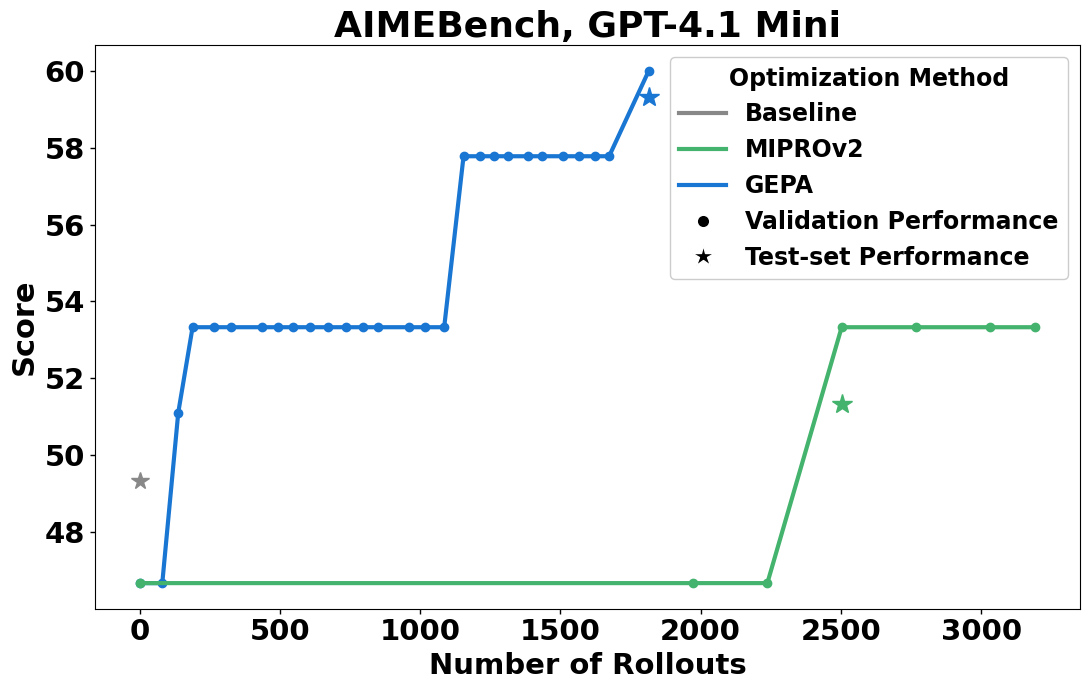

0.5340000000000004


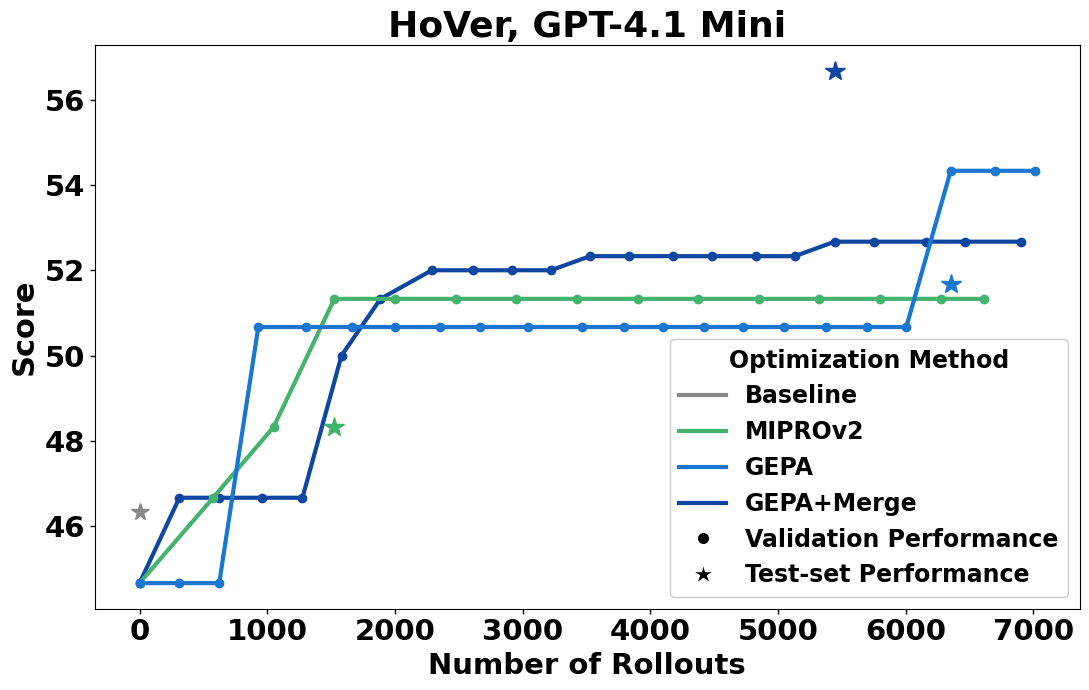

0.802000000000001


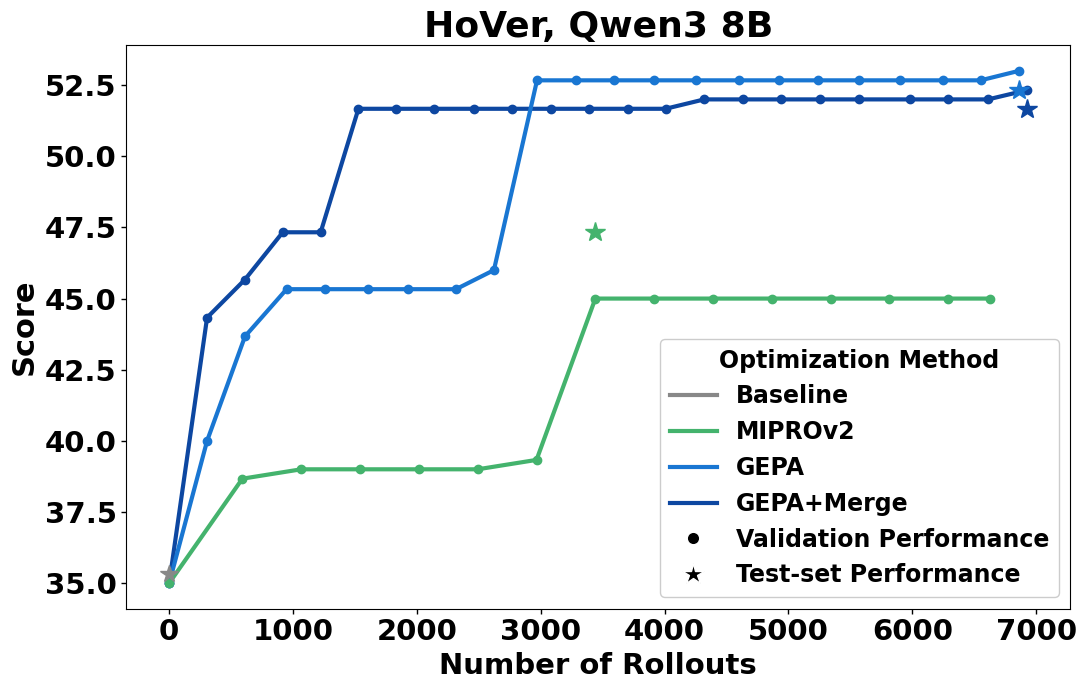

0.7233333333333339


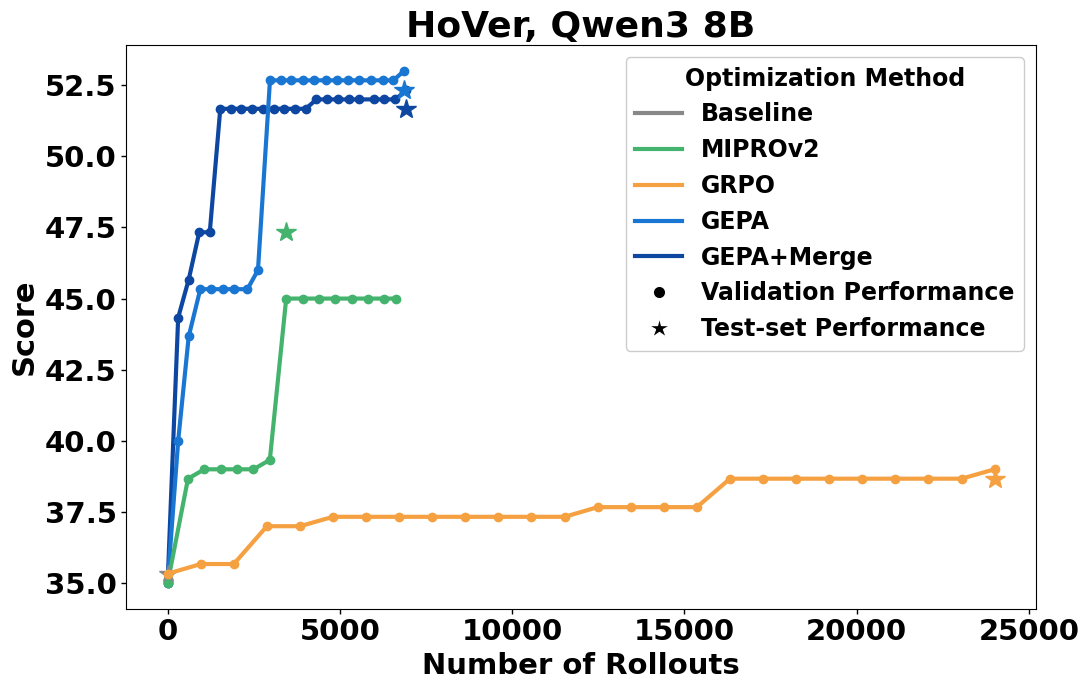

2.2639999999999985


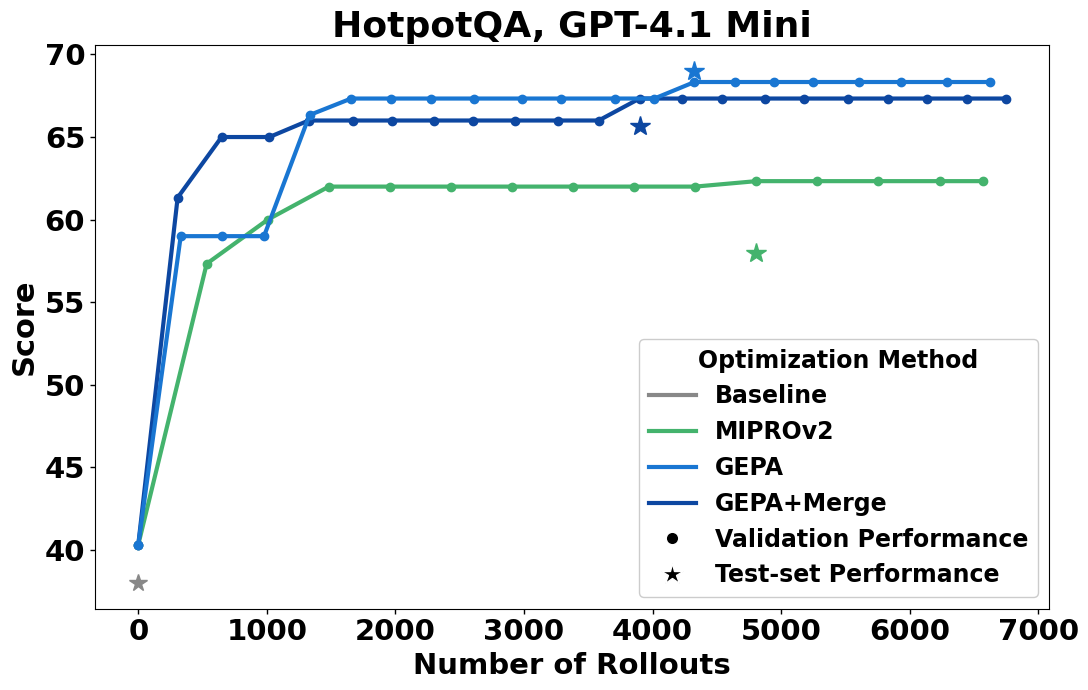

1.004000000000002


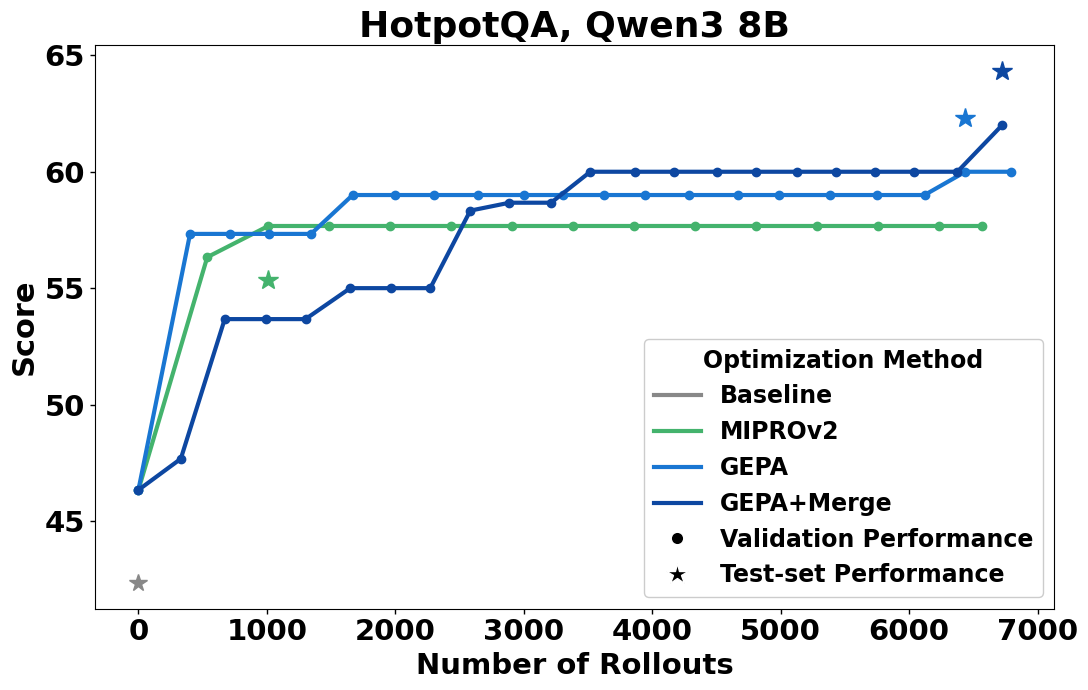

2.3366666666666682


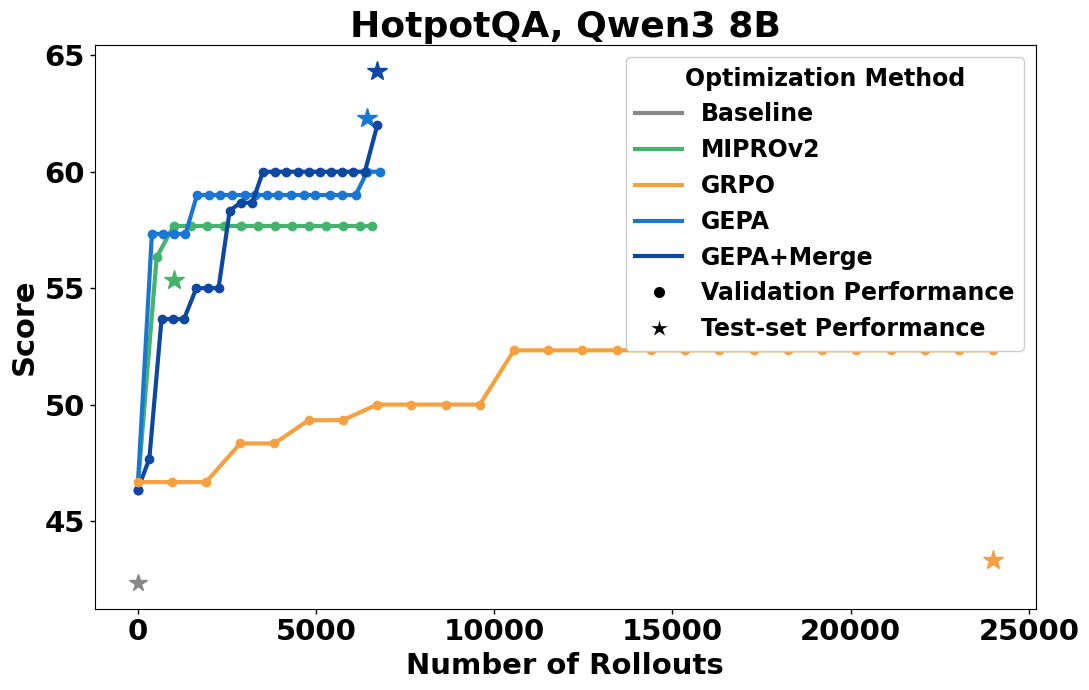

37.763999999999996


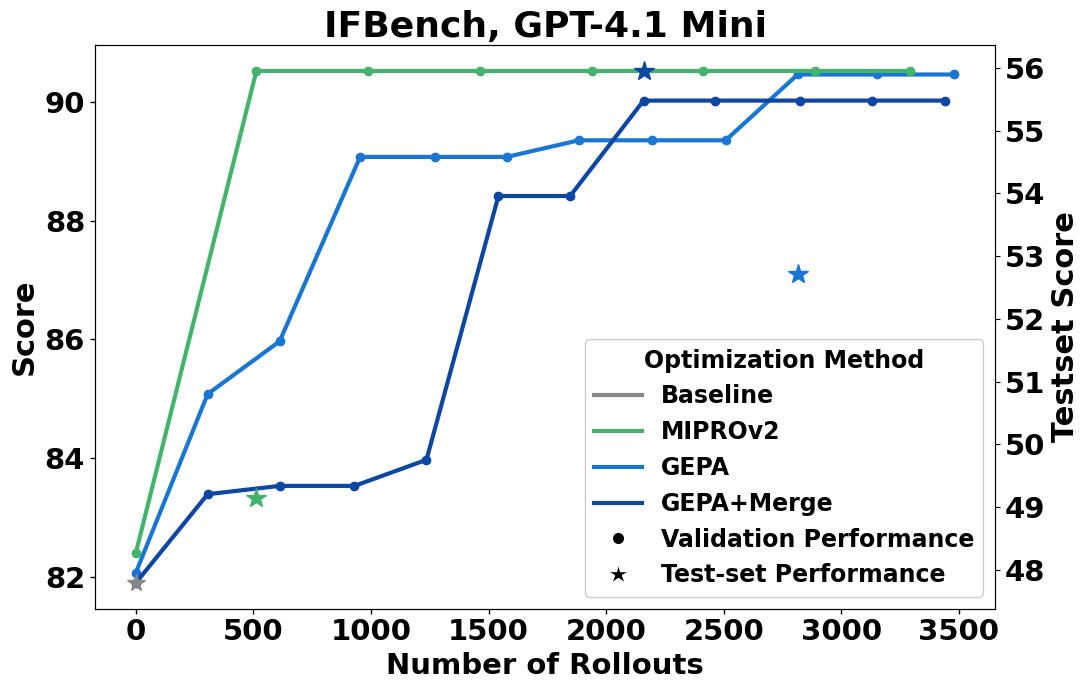

40.63399999999999


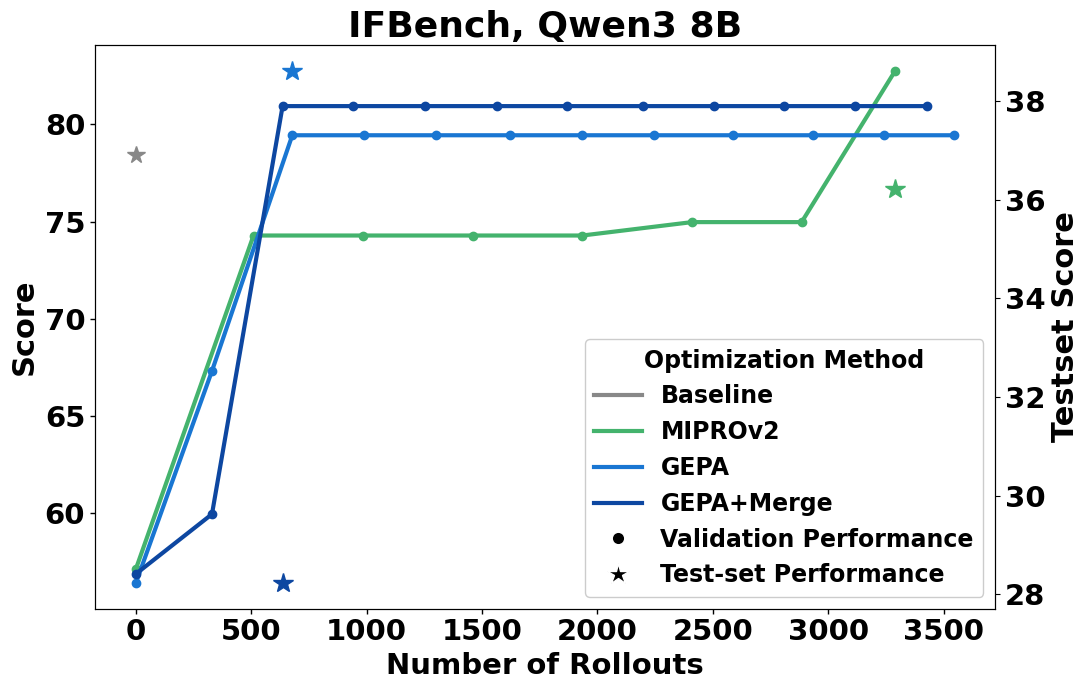

38.459999999999994


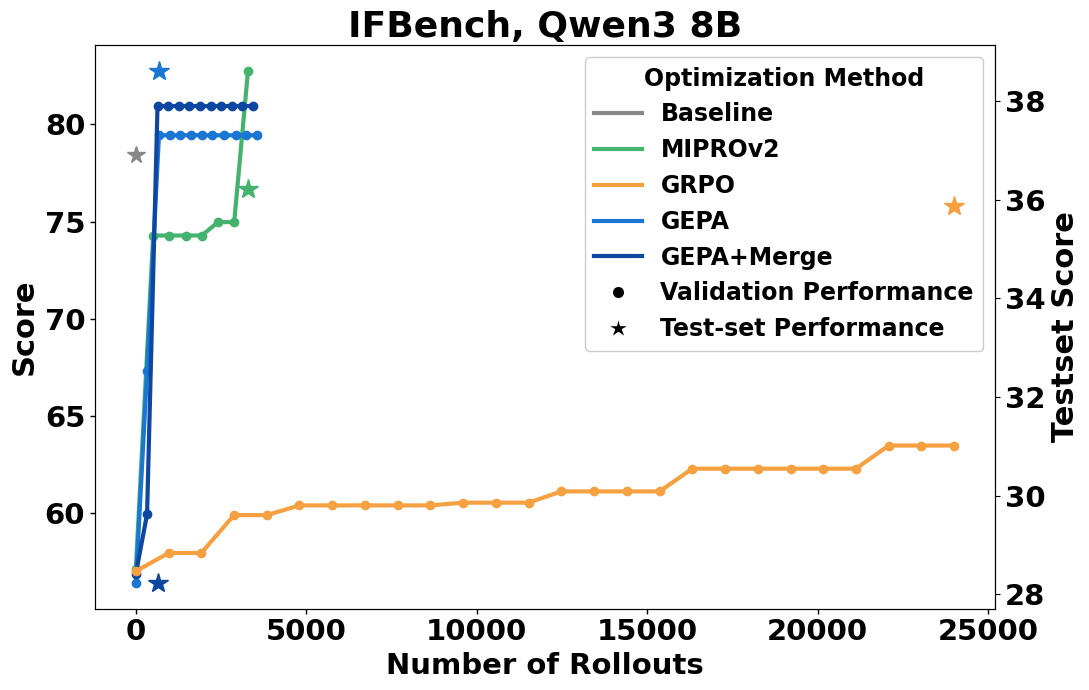

1.824000000000001


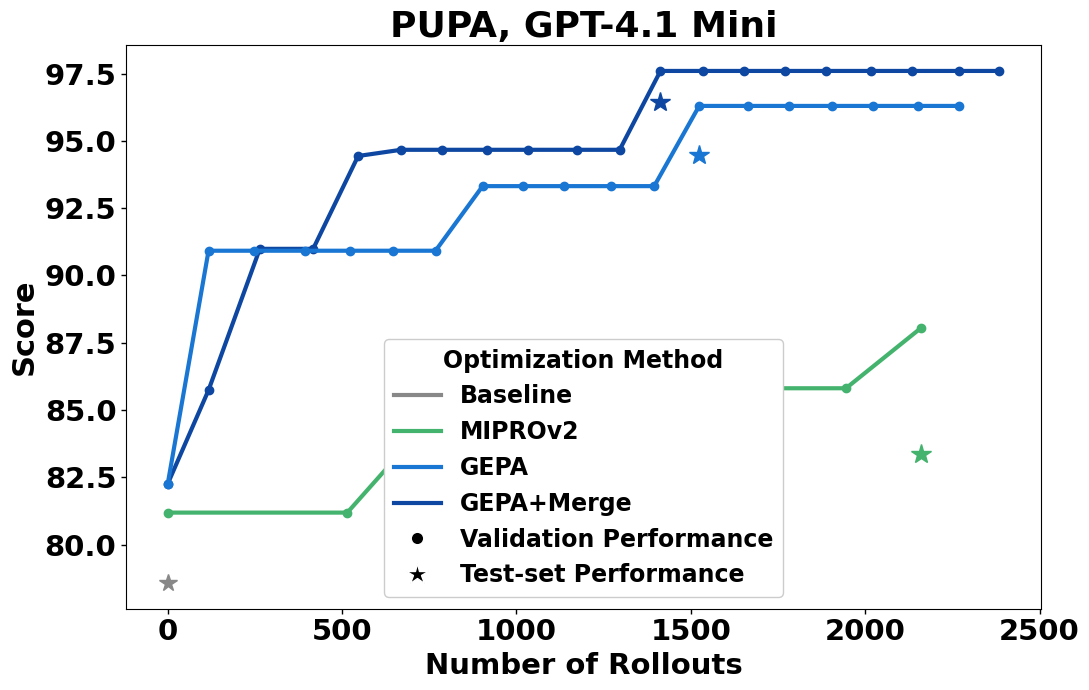

1.4120000000000033


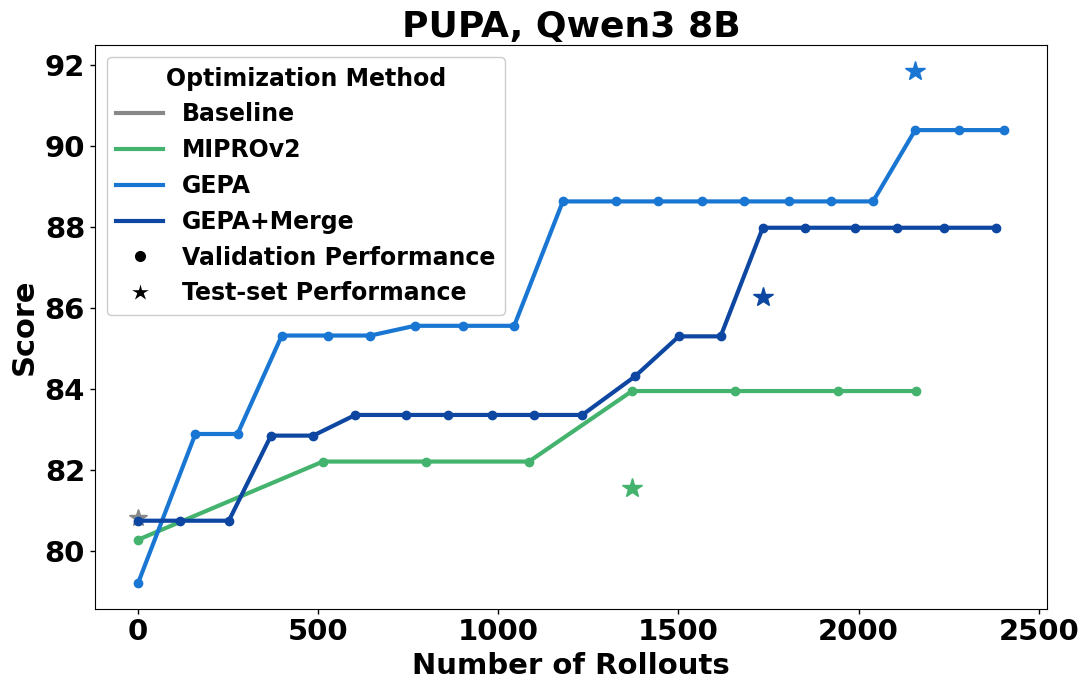

1.1733333333333367


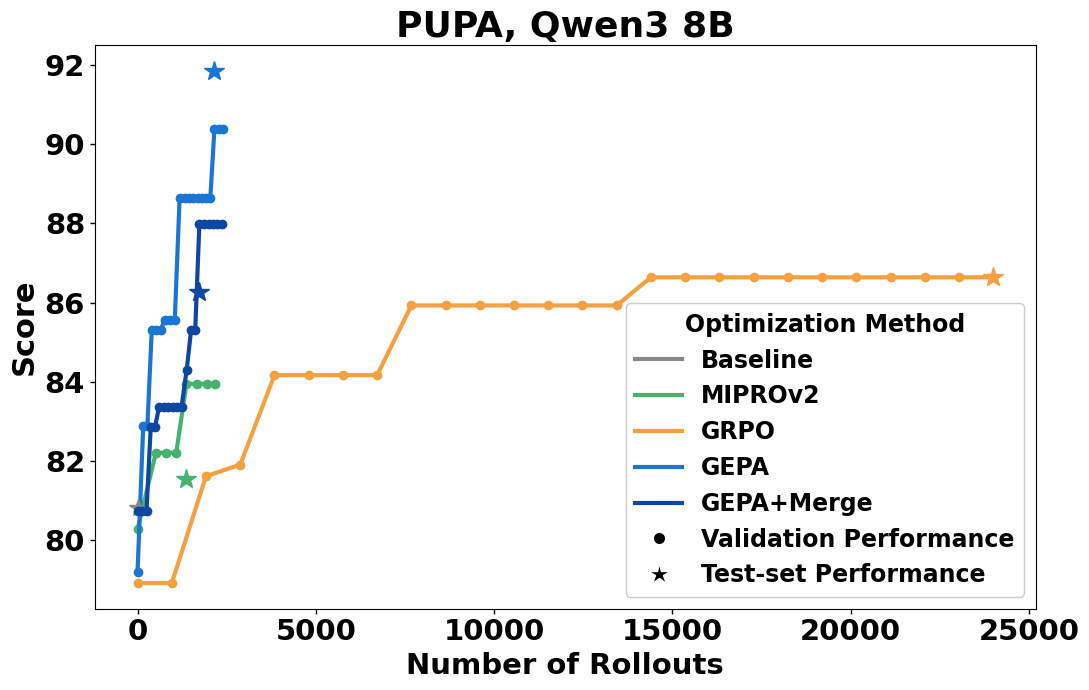

10.352500000000001


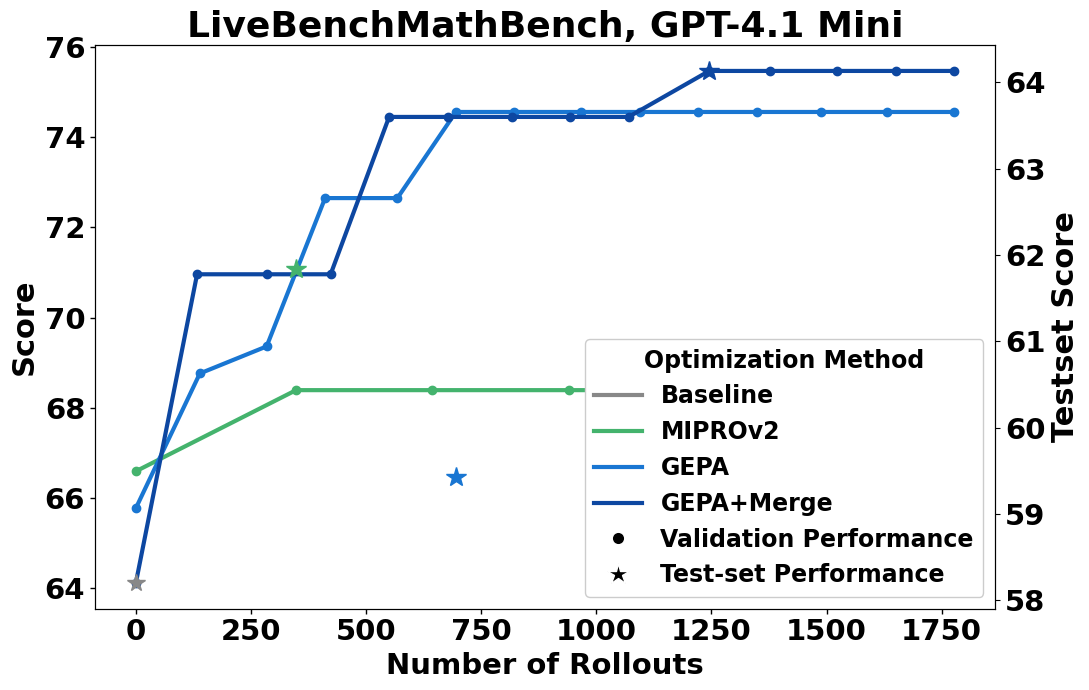

In [8]:
colors = color_map

import matplotlib.pyplot as plt
import pandas as pd

for include_testset in [True]: # False
    for bench in df['bench'].unique():
        for model in df['model'].unique():
            for include_grpo in [False, True]:
                for include_gepawmerge in [True]: # False,
                    xdf = df.loc[(df['bench'] == bench) & (df['model'] == model)]
                    if not xdf['opt'].str.contains('GRPO').any() and include_grpo:
                        continue
                    if not include_grpo:
                        xdf = xdf.loc[~xdf['opt'].str.contains('GRPO')]
                    if not include_gepawmerge:
                        xdf = xdf.loc[~xdf['opt'].str.contains('GEPA-MERGE')]
                    
                    if xdf.shape[0] == 0:
                        continue

                    # fig, ax = plt.subplots(figsize=(16, 15))
                    fig, ax = plt.subplots(figsize=(11, 7))
                    print((xdf['best_validation_score'] - xdf['score']).mean())
                    needs_ax2 = include_testset and (xdf['best_validation_score'] - xdf['score']).abs().mean() > 10
                    if include_testset:
                        if needs_ax2:
                            ax2 = ax.twinx()
                            ax2.set_ylabel("Testset Score", fontdict=YLABEL_FONT)
                            ax2.tick_params(axis='y', labelsize=YTICK_FONT['fontsize'])
                            for label in ax2.get_yticklabels():
                                label.set_fontweight(YTICK_FONT['fontweight'])
                        else:
                            ax2 = ax
                    for idx, row in xdf.iterrows():
                        if row['opt'] in ['GEPA-Abl-SBC', 'GEPA-MERGEWLinear']:
                            continue
                        if row['num_rollouts'] is not None and row['full_eval_scores'] is not None:
                            # get color by opt
                            color = colors.get(row['opt'], 'black')
                            ax.plot(
                                row['num_rollouts'],
                                pd.Series(row['full_eval_scores']).cummax(),
                                label=f"{row['opt']}",
                                marker='o',
                                color=color,
                                linewidth=3,
                                markersize=6,
                            )

                        # Plot a special marker point (row['num_rollouts_for_best_program'], row['score']) with a star
                        if include_testset and row['opt'] == 'Baseline':
                            ax2.plot(
                                0,
                                row['score'],
                                marker='*',
                                markersize=13,
                                color=colors.get(row['opt'], 'black'),
                                linestyle='None',
                            )
                        elif row['num_rollouts_for_best_program'] is not None and row['score'] is not None and include_testset:
                            ax2.plot(
                                row['num_rollouts_for_best_program'] if not row['opt'] == 'GRPO' else row['last_rollout_for_prog_discovered'],
                                row['score'],
                                marker='*',
                                markersize=15,
                                color=colors.get(row['opt'], 'black'),
                                linestyle='None',
                            )

                    ax.set_title(
                        f"{benchmark_nicknames.get(bench, bench)}, {model_nickname.get(model, model)}",
                        fontdict=TITLE_FONT
                    )
                    ax.set_xlabel("Number of Rollouts", fontdict=XTICK_FONT)
                    ax.set_ylabel("Score", fontdict=YLABEL_FONT)
                    
                    # Set tick label font
                    ax.tick_params(axis='x', labelsize=XTICK_FONT['fontsize'], width=1)
                    ax.tick_params(axis='y', labelsize=YTICK_FONT['fontsize'], width=1)
                    for label in ax.get_xticklabels():
                        label.set_fontweight(XTICK_FONT['fontweight'])
                    for label in ax.get_yticklabels():
                        label.set_fontweight(YTICK_FONT['fontweight'])

                    handles, labels = ax.get_legend_handles_labels()

                    def get_opt_from_label(label):
                        # Extracts the opt part from "OPT (MODEL)" (first word before space and paren)
                        return label.split()[0]

                    order = {opt: i for i, opt in enumerate(color_map.keys())}

                    # zip, sort, and separate
                    sorted_items = sorted(zip(handles, labels), key=lambda x: order.get(get_opt_from_label(x[1]), float('inf')))
                    sorted_handles = [item[0] for item in sorted_items]
                    # Make the handles just lines, without markers
                    sorted_handles = [plt.Line2D([], [], color=handle.get_color(), linewidth=handle.get_linewidth(), linestyle='-') for handle in sorted_handles]
                    sorted_labels = [opt_nicknames.get(item[1], item[1]).replace(' (24000 rollouts)', '') for item in sorted_items]

                    # Add new handle '*' for the special marker
                    if include_testset:
                        o_handle = plt.Line2D([], [], marker='o', color='w', markerfacecolor='k', markersize=9, linestyle='None')
                        sorted_handles.append(o_handle)
                        sorted_labels.append('Validation Performance')
                        star_handle = plt.Line2D([], [], marker='*', color='w', markerfacecolor='k', markersize=16, linestyle='None')
                        sorted_handles.append(star_handle)
                        sorted_labels.append('Test-set Performance')

                    ax.legend(
                        sorted_handles, sorted_labels, 
                        title='Optimization Method',
                        prop=LEGEND_FONT,
                        title_fontproperties=LEGEND_FONT,
                        framealpha=1.0,
                    )

                    # plt.grid()
                    plt.tight_layout()

                    if include_testset and not include_gepawmerge:
                        plt.savefig(f"figures/{bench}_{model}_{include_grpo}_rollout_vs_score.pdf", dpi=300)
                    elif include_testset and include_gepawmerge:
                        plt.savefig(f"figures/{bench}_{model}_{include_grpo}_rollout_vs_score_gepawmerge.pdf", dpi=300)
                    elif not include_testset and not include_gepawmerge:
                        plt.savefig(f"figures/{bench}_{model}_{include_grpo}_rollout_vs_score_wotestset.pdf", dpi=300)
                    elif not include_testset and include_gepawmerge:
                        plt.savefig(f"figures/{bench}_{model}_{include_grpo}_rollout_vs_score_gepawmerge_wotestset.pdf", dpi=300)
                    else:
                        raise ValueError("Unexpected combination of include_testset and include_gepawmerge flags.")
                    plt.show()

In [9]:
color_map = {
    'Baseline': '#888888',        # grey
    'MIPROv2': '#44b36d',         # green
    'GRPO': '#f5a142',            # orange
    'GEPA-Abl-SBC': '#bbdefb',     # light blue
    'GEPA-MERGEWLinear': '#64b5f6', # medium blue
    'GEPA': '#1976d2',            # deep blue
    'GEPA-MERGE': '#0d47a1',      # darkest blue
}

# =================== Font and Style Configurations ===================

from matplotlib.font_manager import FontProperties
XTICK_FONT = {'fontsize': 18, 'fontweight': 'bold'}
YTICK_FONT = {'fontsize': 18, 'fontweight': 'bold'}
TITLE_FONT = {'fontsize': 22, 'fontweight': 'bold'}
YLABEL_FONT = {'fontsize': 20, 'fontweight': 'bold'}
ANNOT_FONT = {'fontsize': 13.5, 'fontweight': 'bold'}  # For ax.text
LEGEND_FONT = FontProperties(family='sans-serif', size=15, weight='bold')
# =====================================================================

model_nickname = {
    'qwen3-8b': 'Qwen3 8B',
    'gpt-41-mini': 'GPT-4.1 Mini',
}

benchmark_nicknames = {
    'hoverBench': 'HoVer',
    'IFBench': 'IFBench',
    'HotpotQABench': 'HotpotQA',
    # 'FacilitySupportAnalyzerBench': 'FSABench',
    'Papillon': 'PUPA'
}

opt_nicknames = {
    'Baseline': 'Baseline',        # grey
    'MIPROv2': 'MIPROv2',         # green
    'GRPO': 'GRPO (24000 rollouts)', # orange
    'GEPA-Abl-SBC': 'GEPA-BaselineL',     # light blue
    'GEPA-MERGEWLinear': 'GEPA-BaselineLM', # medium blue
    'GEPA': 'GEPA',            # deep blue
    'GEPA-MERGE': 'GEPA+Merge',      # darkest blue
}

## Generate GEPA Search Tree Visualization (as Graphviz DOT)

In [10]:
from gepa_artifact.gepa.gepa_utils import find_dominator_programs

def f(x):
    if isinstance(x['pareto_front_programs'], list):
        return find_dominator_programs(x['pareto_front_programs'], x['full_eval_scores'])

df['dominator_program_ids'] = df.apply(f, axis=1)

In [11]:
def dag_to_dot(parent_program_for_candidate, dominator_program_ids, best_program_idx, full_eval_scores):
    dot_lines = [
        "digraph G {",
        "    node [style=filled, shape=circle, fontsize=50];"
    ]
    n = len(parent_program_for_candidate)
    # Set up nodes with colors and scores in labels
    for idx in range(n):
        score = full_eval_scores[idx]
        label = f"{idx}\\n({score})"
        if idx == best_program_idx:
            dot_lines.append(f'    {idx} [label="{label}", fillcolor=cyan, fontcolor=black];')
        elif idx in dominator_program_ids:
            dot_lines.append(f'    {idx} [label="{label}", fillcolor=orange, fontcolor=black];')
        else:
            dot_lines.append(f'    {idx} [label="{label}"];')
    
    # Set up edges
    for child, parents in enumerate(parent_program_for_candidate):
        for parent in parents:
            if parent is not None:
                dot_lines.append(f'    {parent} -> {child};')
    
    dot_lines.append("}")
    return "\n".join(dot_lines)

In [12]:
for idx, row in df.iterrows():
    if 'GEPA' not in row['opt']:
        continue

    dot_code = dag_to_dot(
        parent_program_for_candidate=row['parent_program_for_candidate'],
        dominator_program_ids=row['dominator_program_ids'],
        best_program_idx=row['best_program_idx'],
        full_eval_scores=row['full_eval_scores']
    )

    os.makedirs("figures/dag_dots", exist_ok=True)
    with open(f"figures/dag_dots/{row['bench']}_{row['prog']}_{row['model']}_{row['opt']}.dot", 'w') as f:
        f.write(dot_code)

## Analyze Prompt Sizes

In [13]:
def demo_to_text(demo, idx):
    demo = {k:v for k, v in demo.items() if k != 'augmented'}
    text = "Example {}:\n".format(idx)
    for k, v in demo.items():
        text += f"{k}:\n"
        text += f"    {v}\n"
    return text + "\n"

def pred_to_text(pred):
    text = ""
    text += f"{pred.signature.instructions}\n"
    if len(pred.demos) == 0:
        return text
    text += "Demos:\n"
    for idx, demo in enumerate(pred.demos):
        text += demo_to_text(demo, idx+1)
    return text

def program_to_text(program):
    if not program:
        return None
    program_text = ""

    for name, mipro_pred in program.named_predictors():
        mipro_program_to_text = pred_to_text(mipro_pred)
        program_text += f"Predictor: {name}\n"
        program_text += mipro_program_to_text + "\n"

    return program_text.strip()

In [14]:
df['best_program_full_text'] = df['best_program'].apply(program_to_text)

In [15]:
from transformers import AutoTokenizer
import tiktoken
qwen3_tok = AutoTokenizer.from_pretrained('qwen/qwen3-8b')
tokenizers = {
    'qwen3-8b': lambda x: qwen3_tok(x)['input_ids'],
    'gpt-41-mini': tiktoken.encoding_for_model("gpt-4o").encode
}

In [16]:
def f(x):
    if not x['best_program_full_text']:
        return None  # If no program, return 0 tokens
    model = x['model']
    tokenizer = tokenizers[model]
    tokens = tokenizer(x['best_program_full_text'])
    return len(tokens)

df['best_program_prompt_token_count'] = df.apply(f, axis=1)

In [17]:
opt_nicknames_2 = opt_nicknames.copy()
opt_nicknames_2['GEPA-Abl-SBC'] = 'Abl:SelectBestCandidate'

### Aggregate Performance vs. Prompt Size

/tmp/ipykernel_1719417/96681220.py:7: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  xdf = df.loc[~df['opt'].isin(['GEPA-MERGEWLinear'])].groupby(['model', 'opt']).apply(


,model,opt,score,best_program_prompt_token_count,family,opt_color,opt_label,model_label
0,gpt-41-mini,GEPA,64.436667,1550.833333,GEPA,#1976d2,GEPA,GPT-4.1 Mini
1,gpt-41-mini,GEPA-Abl-SBC,65.130000,2097.750000,GEPA,#bbdefb,Abl:SelectBestCandidate,GPT-4.1 Mini
2,gpt-41-mini,GEPA-MERGE,67.776000,1378.800000,GEPA,#0d47a1,GEPA+Merge,GPT-4.1 Mini
3,gpt-41-mini,MIPROv2,58.670000,6539.000000,MIPROv2,#44b36d,MIPROv2,GPT-4.1 Mini


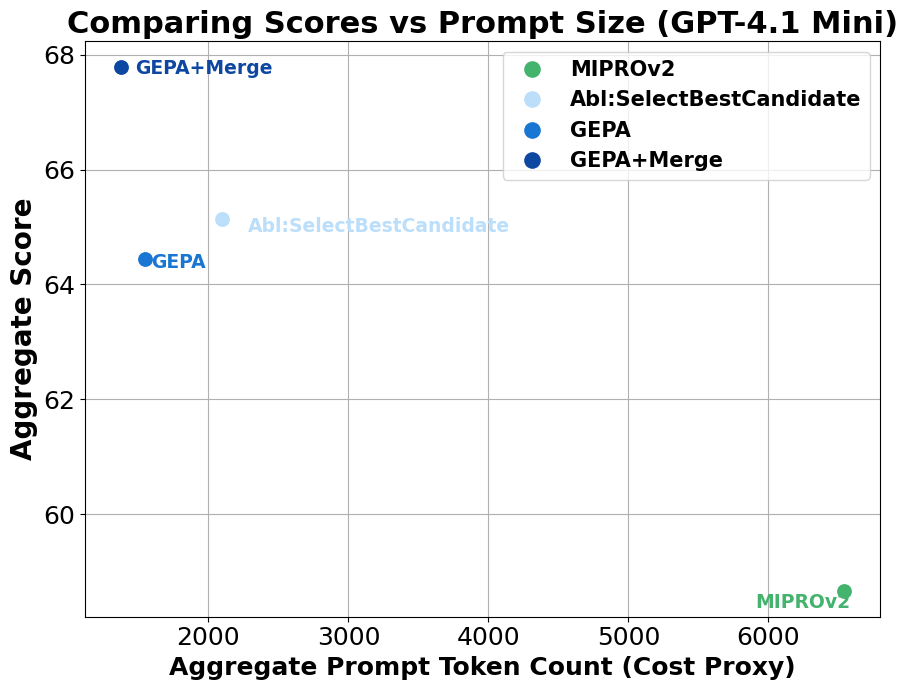

/tmp/ipykernel_1719417/96681220.py:7: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  xdf = df.loc[~df['opt'].isin(['GEPA-MERGEWLinear'])].groupby(['model', 'opt']).apply(


,model,opt,score,best_program_prompt_token_count,family,opt_color,opt_label,model_label
0,qwen3-8b,GEPA,61.2800,1280.25,GEPA,#1976d2,GEPA,Qwen3 8B
1,qwen3-8b,GEPA-Abl-SBC,54.8875,1997.75,GEPA,#bbdefb,Abl:SelectBestCandidate,Qwen3 8B
2,qwen3-8b,GEPA-MERGE,57.6225,1402.50,GEPA,#0d47a1,GEPA+Merge,Qwen3 8B
3,qwen3-8b,MIPROv2,55.1075,6259.00,MIPROv2,#44b36d,MIPROv2,Qwen3 8B


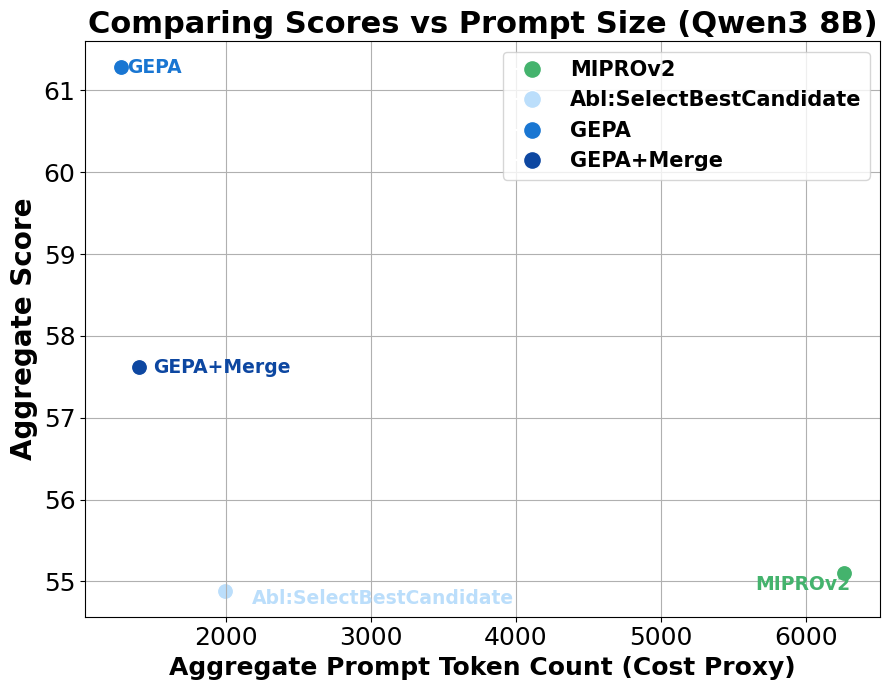

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from adjustText import adjust_text

for model_name in df['model'].unique():
    xdf = df.loc[~df['opt'].isin(['GEPA-MERGEWLinear'])].groupby(['model', 'opt']).apply(
        lambda x: x[['score', 'best_program_prompt_token_count']].mean(numeric_only=True)
    ).dropna()
    xdf = xdf.loc[xdf.index.get_level_values(0).str.contains(model_name)]

    xdf = xdf.reset_index()
    # Add family or use opt as grouping key if desired
    xdf['family'] = xdf['opt'].map(lambda x: 'GEPA' if 'GEPA' in x else 'MIPROv2')

    # To map color and readable name
    xdf['opt_color'] = xdf['opt'].map(color_map)
    xdf['opt_label'] = xdf['opt'].map(opt_nicknames_2).fillna(xdf['opt'])
    xdf['model_label'] = xdf['model'].map(model_nickname).fillna(xdf['model'])

    # --- Plotting ---

    plt.figure(figsize=(9, 7))
    ax = plt.gca()

    # Plot each group (opt) manually for full color control
    markers = ['o', 's', '^', 'D', 'X', 'P', '*']  # Expand if you have more models
    model_list = list(xdf['model'].unique())

    for opt, group in xdf.groupby('opt'):
        label = opt_nicknames_2.get(opt, opt)
        color = color_map.get(opt, '#555555')
        for i, (_, row) in enumerate(group.iterrows()):
            model = row['model']
            marker = markers[model_list.index(model) % len(markers)]
            sns.scatterplot(
                x=[row['best_program_prompt_token_count']],
                y=[row['score']],
                marker=marker,
                color=color,
                s=135,
                edgecolor='white',
                legend=False,
                ax=ax
            )

    # --- Combined Legend (color = config, marker = model) ---

    # Algo config legend handles (color)
    opt_handles, opt_labels = [], []
    for opt in opt_nicknames_2.keys():
        if opt not in xdf['opt'].unique():
            continue
            # Use color_map to get the color for this opt
        color = color_map.get(opt, '#555555')
        h = plt.Line2D([0], [0], marker='o', color='w',
                    markerfacecolor=color, markersize=13, label=opt_nicknames_2.get(opt, opt))
        opt_handles.append(h)
        opt_labels.append(opt_nicknames_2.get(opt, opt))

    # # Model legend handles (marker, black)
    # model_handles, model_labels = [], []
    # for idx, model in enumerate(model_list):
    #     marker = markers[idx % len(markers)]
    #     m = plt.Line2D([0], [0], marker=marker, color='k', linestyle='None', markersize=11,
    #                 label=model_nickname.get(model, model))
    #     model_handles.append(m)
    #     model_labels.append(model_nickname.get(model, model))

    # Concatenate
    all_handles = opt_handles #+ model_handles
    all_labels = opt_labels #+ model_labels

    # Set single legend
    ax.legend(all_handles, all_labels, prop=LEGEND_FONT, frameon=True, title_fontsize=10) # loc='lower right',

    # --- Axis and title stylings ---
    ax.set_xlabel('Aggregate Prompt Token Count (Cost Proxy)', **XTICK_FONT)
    ax.set_ylabel('Aggregate Score', **YLABEL_FONT)
    ax.set_title(f"Comparing Scores vs Prompt Size ({model_nickname.get(model_name, model_name)})", **TITLE_FONT)
    ax.tick_params(axis='x', labelsize=XTICK_FONT['fontsize'])
    ax.tick_params(axis='y', labelsize=YTICK_FONT['fontsize'])

    # === Annotate points using adjustText ===
    texts = []
    x_buffer = 0  # How much to push label horizontally (in token units on x-axis)
    x_min, x_max = ax.get_xlim()

    for _, row in xdf.iterrows():
        x = row['best_program_prompt_token_count']
        y = row['score']

        # By default, try annotating to the right
        annot_x = x + x_buffer
        annot_ha = 'left'

        # If too close to right edge, annotate to the left
        if annot_x > x_max:
            annot_x = x - x_buffer
            annot_ha = 'right'

        texts.append(
            ax.text(
                annot_x, y,
                row['opt_label'],
                va='center',
                ha=annot_ha,
                color=row['opt_color'],
                **ANNOT_FONT
            )
        )

    adjust_text(
        texts,
        ax=ax,
        expand_text=(1.3, 1.3),
        expand_points=(2.1, 2.1),
        lim=1000,
    )
    plt.grid()
    plt.tight_layout()
    display(xdf)
    plt.savefig(f"figures/aggregate_performance_vs_prompt_size_{model_name}.pdf", dpi=300)
    plt.show()

### Final Prompt Size across benchmarks

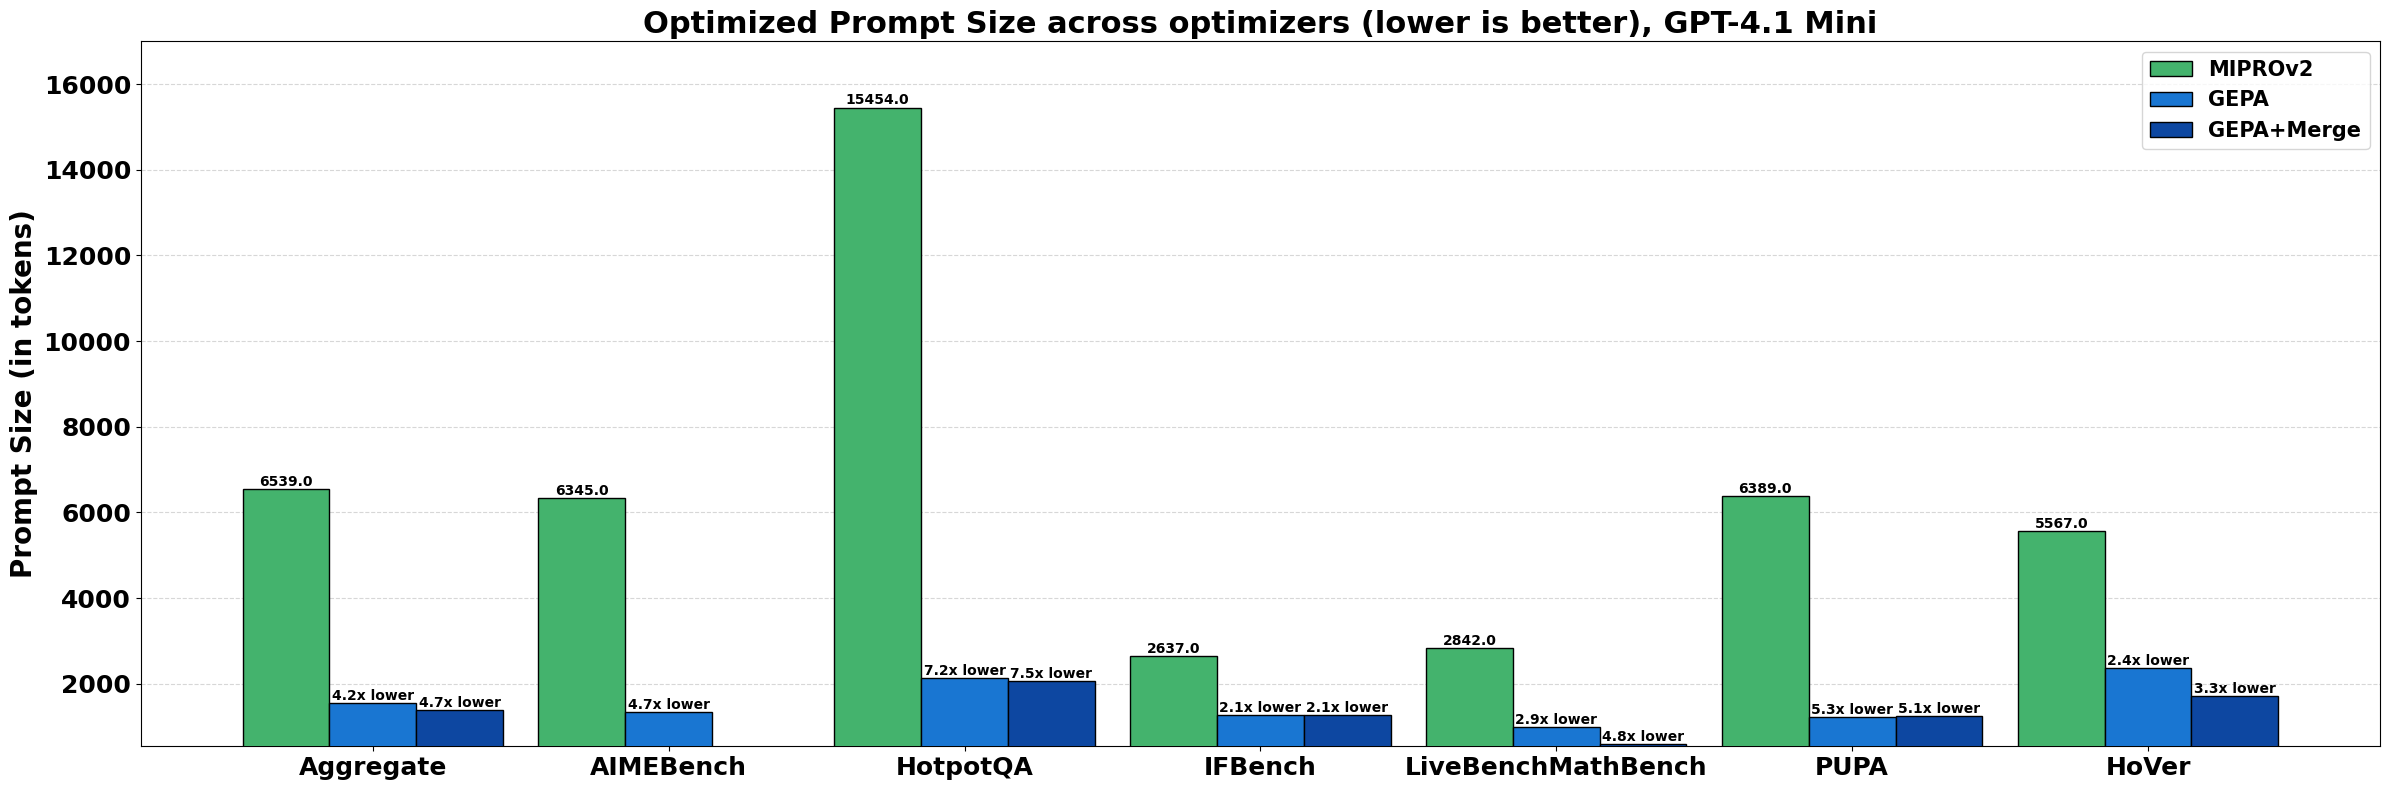

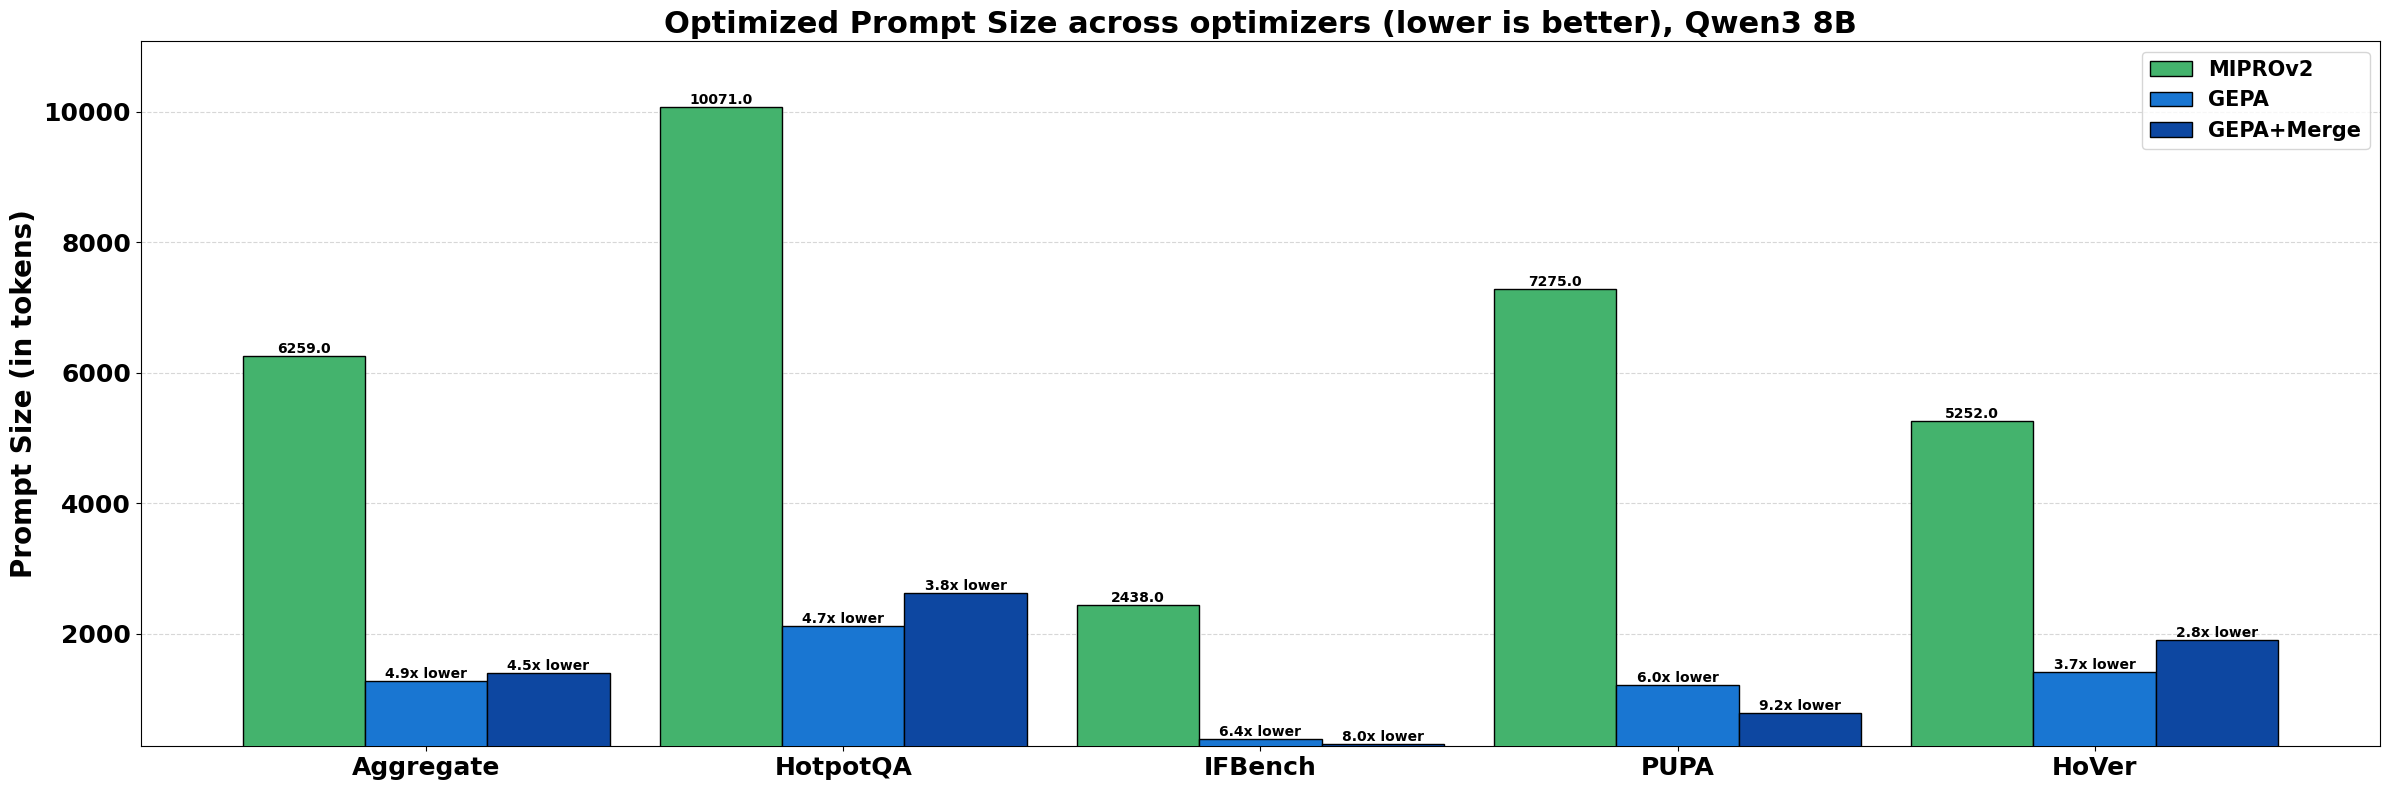

In [19]:
for model_name in df['model'].unique():
    # Subset for model
    sub = df.loc[df['model'] == model_name].loc[~df['opt'].isin(['GEPA-Abl-SBC', 'GEPA-MERGEWLinear'])]

    # Pivot: rows=opts, columns=bench, values=score
    xdf = sub.pivot(index='opt', columns='bench', values='best_program_prompt_token_count')

    # Add rows for all opts in opts_order, preserve what is present
    xdf = xdf.reindex(opts_order)
    # Drop opts with no data
    xdf = xdf.loc[xdf.notna().any(axis=1)]

    # Add aggregate column (mean of all benches per opt)
    bench_order = xdf.columns.tolist()
    xdf['Aggregate'] = xdf[bench_order].mean(axis=1)
    bench_labels = ['Aggregate'] + [benchmark_nicknames.get(b, b) for b in bench_order]

    # Make sure all benches are represented (add columns if missing)
    for b in bench_order:
        if b not in xdf.columns:
            xdf[b] = np.nan

    # Order columns for plotting: aggregate, then each benchmark
    plot_df = xdf[['Aggregate'] + bench_order]
    # Only plot rows for present opts
    present_opts = [opt for opt in opts_order if opt in plot_df.index and not plot_df.loc[opt].isna().all()]

    plot_df = plot_df.loc[present_opts]

    n_opts = len(present_opts)
    n_benches = plot_df.shape[1]
    x = np.arange(n_benches)

    group_width = 0.88
    bar_width = group_width / n_opts

    fig, ax = plt.subplots(figsize=(24, 8))
    mipro_row = xdf.loc['MIPROv2'] if 'MIPROv2' in xdf.index else None
    for i, opt in enumerate(present_opts):
        opt_color = color_map.get(opt, '#bbbbbb')
        y = plot_df.loc[opt].values
        bar_pos = x - group_width/2 + i*bar_width + bar_width/2
        bars = ax.bar(
            bar_pos,
            y,
            width=bar_width,
            label=opt_nicknames.get(opt, opt),
            color=opt_color,
            edgecolor='k',
            zorder=3
        )
        for j, (xi, val) in enumerate(zip(bar_pos, y)):
            if np.isnan(val):
                continue

            bench = plot_df.columns[j]
            if opt == "MIPROv2":
                annot_text = f"{val:.1f}"
            else:
                # mipro value for this benchmark
                if mipro_row is not None:
                    mipro_val = mipro_row[bench]
                    if np.isnan(mipro_val):
                        annot_text = "?"
                    else:
                        annot_text = f"{mipro_val/val:.1f}x lower"
                else:
                    annot_text = f"?/{val:.1f}"
            ANNOT_FONT = {'fontsize': 10, 'fontweight': 'bold'}
            ax.text(xi, val + 1, annot_text, ha='center', va='bottom', **ANNOT_FONT)

    # Set y axis limits
    y_min = max(0, 0.9 * plot_df.min().min())
    y_max = plot_df.max().max() * 1.1
    ax.set_ylim(y_min, y_max)

    # X ticks/labels
    ax.set_xticks(x)
    ax.set_xticklabels(bench_labels, **XTICK_FONT)
    ax.set_ylabel('Prompt Size (in tokens)', **YLABEL_FONT)
    ax.set_title(f'Optimized Prompt Size across optimizers (lower is better), {model_nickname.get(model_name, model_name)}', **TITLE_FONT)

    # Y ticks labels font
    for label in ax.get_yticklabels():
        label.set_fontsize(YTICK_FONT['fontsize'])
        label.set_fontweight(YTICK_FONT['fontweight'])

    ax.legend(prop=LEGEND_FONT)
    ax.grid(True, axis='y', linestyle='--', alpha=0.5, zorder=0)
    plt.tight_layout()
    plt.savefig(f"figures/prompt_size_comparison_{model_name}.pdf", dpi=300)
    plt.show()